In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
from keras.engine import data_adapter
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v5 import Autoencoder
from tools.GRU_AR_v7 import AR_RNN_GRU
from tools.AEGRU_AR_v1 import AR_AERNN_GRU
from tools.trainAERNN import trainAERNN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpoin?tAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2022-12-18 16:06:31.546641: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 16:06:31.547144: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 16:06:31.597230: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 16:06:31.597536: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 16:06:31.597878: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [10]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [11]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_043'

    # making AR-RNN save directory
    dir_name_ARrnn = os.getcwd() + dir_sep + 'saved_AR_AERNN_rnn'
    if not os.path.isdir(dir_name_ARrnn):
        os.makedirs(dir_name_ARrnn)

    counter = 0
    while True:
        dir_check = 'AR_rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ARrnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ARrnn = dir_name_ARrnn + dir_sep + dir_check
    os.makedirs(dir_name_ARrnn)
    os.makedirs(dir_name_ARrnn+dir_sep+'plots')
    
    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    try:
        dense_layer_act_func = params_rnn_dict['dense_layer_act_func']
    except:
        print("'dense_layer_act_func' not present in RNN_specific_data, set to 'linear'.")
        dense_layer_act_func = 'linear'
    try:
        stateful = params_rnn_dict['stateful']
    except:
        print("'stateful' not present in RNN_specific_data, set to True.")
        stateful = True
    try:
        use_learnable_state = params_rnn_dict['use_learnable_state']
    except:
        print("'use_learnable_state' not present in RNN_specific_data, set to False.")
        use_learnable_state = False
    try:
        use_weights_post_dense = params_rnn_dict['use_weights_post_dense']
    except:
        print("'use_weights_post_dense' not present in RNN_specific_data, set to False.")
        use_weights_post_dense = False
        
    
    # training params
    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0

    loss_weights = 0.98
else:
    # AR-RNN directory
    dir_name_ARrnn = os.getcwd()+'/saved_AR_AERNN_rnn/AR_AErnn_000'

    # reading AR-RNN parameters
    with open(dir_name_ARrnn + '/AR_rnn_specific_data.txt') as f:
        lines = f.readlines()
    
    params_AR_rnn_dict = eval(''.join(lines))

    dir_name_rnn = params_AR_rnn_dict['dir_name_rnn']
    rnn_idx = dir_name_rnn[-3:]
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_'+rnn_idx

    dt_rnn = params_AR_rnn_dict['dt_rnn']
    T_sample_input = params_AR_rnn_dict['T_sample_input']
    T_sample_output = params_AR_rnn_dict['T_sample_output']
    T_offset = params_AR_rnn_dict['T_offset']
    return_params_arr = params_AR_rnn_dict['return_params_arr']
    params = params_AR_rnn_dict['params']
    try:
        normalize_dataset = params_AR_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in AR_rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_AR_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_AR_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        use_ae_data = params_AR_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in RNN_specific_data, set to True.")
        use_ae_data = True

    # training params
    with open(dir_name_ARrnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0
    try:
        loss_weights = tparams_dict['loss_weights']
    except:
        loss_weights = None
    if 'freeze_layers' in tparams_dict.keys():
        freeze_layers = tparams_dict['freeze_layers']
    else:
        freeze_layers = None
    if 'clipnorm' in tparams_dict.keys():
        clipnorm = tparams_dict['clipnorm']
    else:
        clipnorm = None
    


# reading stddev
with open(dir_name_rnn + '/final_net/final_net_class_dict.txt') as f:
    lines = f.readlines()
finalnet_dict = eval(''.join(lines))
stddev = finalnet_dict['stddev']
# stddev = 0.0

# reading RNN normalization constants
normalization_arr_rnn = None
if normalize_dataset == True:
    with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
        lines = f.readlines()
    normarr_rnn_dict = eval(''.join(lines))
    normalization_arr_rnn = normarr_rnn_dict['normalization_arr']

if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_arr_rnn = fl['normalization_arr'][0]

# reading AE directory
with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))

dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]
dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx
try:
    use_ae_data = params_dict['use_ae_data']
except:
    print("'use_ae_data' not present in sim_data_AE_params, set to True.")
    use_ae_data = True

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in RNN_specific_data, set to True.")
    ae_data_with_params = True

print('dir_name_AR_AErnn:', dir_name_ARrnn)
print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state_mat = params_dict['init_state_mat']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data']
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']
    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']


test_split = 1 - train_split - val_split

# setting seed for PRNGs
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

dir_name_AR_AErnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012
dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_043
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_046
data_dir_idx: 005
normalize_flag_ogdata: False


In [12]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [13]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

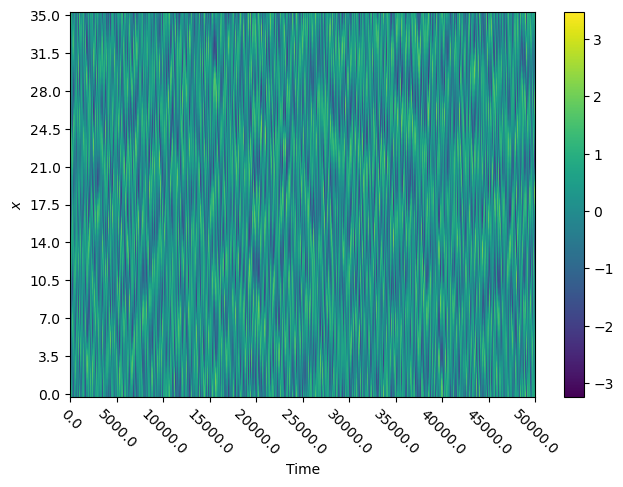

In [14]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [15]:
# # dealing with normalizing the data before feeding into autoencoder
# if use_ae_data == True:
#     if normalizeforae_flag == True:
#         for i in range(numpoints_xgrid):
#             all_data[:, i] -= normalization_constant_arr_aedata[0, i]
#             all_data[:, i] /= normalization_constant_arr_aedata[1, i]

#     if ae_data_with_params == False:
#         all_data = all_data[:, 0:numpoints_xgrid]
# else:
#     # using raw data, neglecting the params attached (if any)
#     all_data = all_data[:, 0:numpoints_xgrid]

if use_ae_data == True and ae_data_with_params == False:
    all_data = all_data[:, 0:numpoints_xgrid]
else:
    all_data = all_data[:, 0:numpoints_xgrid]

# Autoencoder

In [16]:
# if use_ae_data == True:
#     load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
#     wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [17]:
# if use_ae_data == True:
#     ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
#     ae_net.load_weights_from_file(wt_file)

# GRU

In [18]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = np.array([10, 15, 20])*dt_rnn/np.mean(lyapunov_time_arr)
    num_timesteps_warmup = 1*np.mean(lyapunov_time_arr)/dt_rnn
    T_sample_input = num_timesteps_warmup*dt_rnn
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = T_sample_input
    skip_intermediate = 'full sample'
    stateful = True
    if return_params_arr != False:
        params = params_arr
    else:
        params = None

    # saving AR RNN specific data
    AR_RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'num_timesteps_warmup':num_timesteps_warmup,
        'dir_name_rnn':dir_name_rnn,
        'dir_name_ae':dir_name_ae,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':AR_RNN_GRU.__module__,
        'normalization_type':normalization_type,
        'use_ae_data':use_ae_data,
        'stateful':stateful,
    }

    with open(dir_name_ARrnn+dir_sep+'AR_RNN_specific_data.txt', 'w') as f:
        f.write(str(AR_RNN_specific_data))

In [19]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [
        [1e-5],
        [5e-6],
        [1e-6],
    ]
    epochs = [
        [1000],
        [1000],
        [1000],
        
    ]
    patience = [
        [100],
        [100],
        [100],
    ] # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-6  # weight for regularizer
    covmat_lmda = 1e-5  # weight for the covmat loss

    if loss_weights is None:
        loss_weights = 1.0
        
    freeze_layers = [
        [],
        [],
        [],
    ]
    
    clipnorm = 1.0
    batch_size = 32
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'loss_weights':loss_weights,
        'stddev':stddev,
        'covmat_lmda':covmat_lmda,
        'freeze_layers':freeze_layers,
        'clipnorm':clipnorm,
    }

    with open(dir_name_ARrnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_ARrnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr_rnn],
    )

In [20]:
if behaviour == 'initialiseAndTrainFromScratch':
    load_file_rnn = dir_name_rnn + '/final_net/final_net_class_dict.txt'
    wt_file_rnn = dir_name_rnn+'/final_net/final_net_gru_weights.h5'
    
    load_file_ae = dir_name_ae+'/final_net/final_net_class_dict.txt'
    wt_file_ae = dir_name_ae+'/final_net/final_net_ae_weights.h5'



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 10 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************




--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
71/71 [==============================] - ETA: 0s - loss: 0.0132 - mse: 0.0012 - NMSE: 0.0109 - covmat_fro_loss: 7.1146e-04 - tot_time: 0h 0m 56.2s

Epoch 1: val_NMSE improved from inf to 0.00891, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [===================

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 362ms/step - loss: 0.0109 - mse: 9.3322e-04 - NMSE: 0.0084 - covmat_fro_loss: 6.3138e-04 - val_loss: 0.0103 - val_mse: 8.6130e-04 - val_NMSE: 0.0078 - val_covmat_fro_loss: 0.0000e+00
Epoch 13/1000
71/71 [==============================] - ETA: 0s - loss: 0.0108 - mse: 9.2564e-04 - NMSE: 0.0083 - covmat_fro_loss: 6.2915e-04 - tot_time: 0h 6m 5.8s

Epoch 13: val_NMSE improved from 0.00752 to 0.00731, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 27s 383ms/step - loss: 0.0108 - mse: 9.2564e-04 - NMSE: 0.0083 - covmat_fro_loss: 6.2905e-04 - va

Epoch 25/1000
71/71 [==============================] - ETA: 0s - loss: 0.0099 - mse: 8.1521e-04 - NMSE: 0.0073 - covmat_fro_loss: 5.9449e-04 - tot_time: 0h 11m 18.5s

Epoch 25: val_NMSE did not improve from 0.00668
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 364ms/step - loss: 0.0099 - mse: 8.1521e-04 - NMSE: 0.0073 - covmat_fro_loss: 5.9473e-04 - val_loss: 0.0094 - val_mse: 7.5454e-04 - val_NMSE: 0.0068 - val_covmat_fro_loss: 0.0000e+00
Epoch 26/1000
71/71 [==============================] - ETA: 0s - loss: 0.0098 - mse: 7.9962e-04 - NMSE: 0.0072 - covmat_fro_loss: 5.8895e-04 - tot_time: 0h 11m 44.4s

Epoch 26: val_NMSE improved from 0.00668 to 0.00634, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 367ms/step - loss: 0.0092 - mse: 7.3651e-04 - NMSE: 0.0066 - covmat_fro_loss: 5.6895e-04 - val_loss: 0.0089 - val_mse: 6.9588e-04 - val_NMSE: 0.0063 - val_covmat_fro_loss: 0.0000e+00
Epoch 39/1000
71/71 [==============================] - ETA: 0s - loss: 0.0091 - mse: 7.2676e-04 - NMSE: 0.0065 - covmat_fro_loss: 5.6539e-04 - tot_time: 0h 17m 17.7s

Epoch 39: val_NMSE did not improve from 0.00626
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 361ms/step - loss: 0.0091 - mse: 7.2676e-04 - NMSE: 0.0065 - covmat_fro_loss: 5.6637e-04 - val_loss: 0.0089 - val_mse: 6.9822e-04 - val_NMSE: 0.0063 - val_covmat_fro_loss: 0.0000e+00
Epoch 40/1000
71/71 [==============

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 370ms/step - loss: 0.0087 - mse: 6.7795e-04 - NMSE: 0.0061 - covmat_fro_loss: 5.4756e-04 - val_loss: 0.0084 - val_mse: 6.3898e-04 - val_NMSE: 0.0058 - val_covmat_fro_loss: 0.0000e+00
Epoch 52/1000
71/71 [==============================] - ETA: 0s - loss: 0.0086 - mse: 6.7169e-04 - NMSE: 0.0060 - covmat_fro_loss: 5.4477e-04 - tot_time: 0h 22m 57.5s

Epoch 52: val_NMSE did not improve from 0.00575
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 369ms/step - loss: 0.0086 - mse: 6.7169e-04 - NMSE: 0.0060 - covmat_fro_loss: 5.4478e-04 - val_loss: 0.0086 - val_mse: 6.6853e-04 - val_NMSE: 0.0060 - val_covmat_fro_loss: 0.0000e+00
Epoch 53/1000
71/71 [==============

Epoch 65/1000
71/71 [==============================] - ETA: 0s - loss: 0.0082 - mse: 6.3353e-04 - NMSE: 0.0057 - covmat_fro_loss: 5.2855e-04 - tot_time: 0h 28m 37.0s

Epoch 65: val_NMSE did not improve from 0.00553
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 361ms/step - loss: 0.0082 - mse: 6.3353e-04 - NMSE: 0.0057 - covmat_fro_loss: 5.2863e-04 - val_loss: 0.0084 - val_mse: 6.4988e-04 - val_NMSE: 0.0058 - val_covmat_fro_loss: 0.0000e+00
Epoch 66/1000
71/71 [==============================] - ETA: 0s - loss: 0.0082 - mse: 6.3509e-04 - NMSE: 0.0057 - covmat_fro_loss: 5.3121e-04 - tot_time: 0h 29m 3.3s

Epoch 66: val_NMSE did not improve from 0.00553
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 371m

71/71 [==============================] - ETA: 0s - loss: 0.0079 - mse: 5.9387e-04 - NMSE: 0.0053 - covmat_fro_loss: 5.1466e-04 - tot_time: 0h 34m 18.1s

Epoch 78: val_NMSE did not improve from 0.00524
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 366ms/step - loss: 0.0079 - mse: 5.9387e-04 - NMSE: 0.0053 - covmat_fro_loss: 5.1504e-04 - val_loss: 0.0078 - val_mse: 5.8720e-04 - val_NMSE: 0.0053 - val_covmat_fro_loss: 0.0000e+00
Epoch 79/1000
71/71 [==============================] - ETA: 0s - loss: 0.0079 - mse: 5.9432e-04 - NMSE: 0.0053 - covmat_fro_loss: 5.1462e-04 - tot_time: 0h 34m 44.6s

Epoch 79: val_NMSE improved from 0.00524 to 0.00520, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

71/71 [==============================] - ETA: 0s - loss: 0.0077 - mse: 5.7452e-04 - NMSE: 0.0052 - covmat_fro_loss: 5.0667e-04 - tot_time: 0h 39m 59.0s

Epoch 91: val_NMSE improved from 0.00508 to 0.00498, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 27s 375ms/step - loss: 0.0077 - mse: 5.7452e-04 - NMSE: 0.0052 - covmat_fro_loss: 5.0656e-04 - val_loss: 0.0075 - val_mse: 5.5332e-04 - val_NMSE: 0.0050 - val_covmat_fro_loss: 0.0000e+00
Epoch 92/1000
71/71 [==============================] - ETA: 0s - loss: 0.0076 - mse: 5.6331e-04 - NMSE: 0.0051 - covmat_fro_loss: 5.0076e-04 - tot_time: 0h 40m 25.2s

Epoch 92: val_NMSE did not improve from 0.00498
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 371ms/step - loss: 0.0074 - mse: 5.4685e-04 - NMSE: 0.0049 - covmat_fro_loss: 4.9387e-04 - val_loss: 0.0074 - val_mse: 5.4257e-04 - val_NMSE: 0.0049 - val_covmat_fro_loss: 0.0000e+00
Epoch 105/1000
71/71 [==============================] - ETA: 0s - loss: 0.0074 - mse: 5.4969e-04 - NMSE: 0.0049 - covmat_fro_loss: 4.9498e-04 - tot_time: 0h 46m 4.3s

Epoch 105: val_NMSE did not improve from 0.00488
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 359ms/step - loss: 0.0074 - mse: 5.4969e-04 - NMSE: 0.0049 - covmat_fro_loss: 4.9508e-04 - val_loss: 0.0075 - val_mse: 5.5565e-04 - val_NMSE: 0.0050 - val_covmat_fro_loss: 0.0000e+00
Epoch 106/1000
71/71 [============

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 358ms/step - loss: 0.0071 - mse: 5.2029e-04 - NMSE: 0.0047 - covmat_fro_loss: 4.8322e-04 - val_loss: 0.0073 - val_mse: 5.3636e-04 - val_NMSE: 0.0048 - val_covmat_fro_loss: 0.0000e+00
Epoch 118/1000
71/71 [==============================] - ETA: 0s - loss: 0.0071 - mse: 5.2008e-04 - NMSE: 0.0047 - covmat_fro_loss: 4.8375e-04 - tot_time: 0h 51m 43.8s

Epoch 118: val_NMSE did not improve from 0.00475
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 368ms/step - loss: 0.0071 - mse: 5.2008e-04 - NMSE: 0.0047 - covmat_fro_loss: 4.8393e-04 - val_loss: 0.0073 - val_mse: 5.3521e-04 - val_NMSE: 0.0048 - val_covmat_fro_loss: 0.0000e+00
Epoch 119/1000
71/71 [===========

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 27s 373ms/step - loss: 0.0070 - mse: 5.1067e-04 - NMSE: 0.0046 - covmat_fro_loss: 4.7939e-04 - val_loss: 0.0071 - val_mse: 5.1549e-04 - val_NMSE: 0.0046 - val_covmat_fro_loss: 0.0000e+00
Epoch 131/1000
71/71 [==============================] - ETA: 0s - loss: 0.0070 - mse: 5.0622e-04 - NMSE: 0.0046 - covmat_fro_loss: 4.7617e-04 - tot_time: 0h 57m 23.7s

Epoch 131: val_NMSE improved from 0.00464 to 0.00461, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 373ms/step - loss: 0.0070 - mse: 5.0622e-04 - NMSE: 0.0046 - covmat_fro_loss: 4.7645e-04 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 27s 384ms/step - loss: 0.0068 - mse: 4.8828e-04 - NMSE: 0.0044 - covmat_fro_loss: 4.6846e-04 - val_loss: 0.0069 - val_mse: 4.9284e-04 - val_NMSE: 0.0044 - val_covmat_fro_loss: 0.0000e+00
Epoch 144/1000
71/71 [==============================] - ETA: 0s - loss: 0.0068 - mse: 4.8600e-04 - NMSE: 0.0044 - covmat_fro_loss: 4.6665e-04 - tot_time: 1h 3m 3.8s

Epoch 144: val_NMSE did not improve from 0.00444
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 369ms/step - loss: 0.0068 - mse: 4.8600e-04 - NMSE: 0.0044 - covmat_fro_loss: 4.6676e-04 - val_loss: 0.0070 - val_mse: 5.1168e-04 - val_NMSE: 0.0046 - val_covmat_fro_loss: 0.0000e+00
Epoch 145/1000
71/71 [=============

Epoch 157/1000
71/71 [==============================] - ETA: 0s - loss: 0.0066 - mse: 4.6581e-04 - NMSE: 0.0042 - covmat_fro_loss: 4.5728e-04 - tot_time: 1h 8m 45.3s

Epoch 157: val_NMSE did not improve from 0.00437
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 27s 381ms/step - loss: 0.0066 - mse: 4.6581e-04 - NMSE: 0.0042 - covmat_fro_loss: 4.5772e-04 - val_loss: 0.0069 - val_mse: 5.0713e-04 - val_NMSE: 0.0046 - val_covmat_fro_loss: 0.0000e+00
Epoch 158/1000
71/71 [==============================] - ETA: 0s - loss: 0.0067 - mse: 4.7433e-04 - NMSE: 0.0043 - covmat_fro_loss: 4.6164e-04 - tot_time: 1h 9m 11.8s

Epoch 158: val_NMSE did not improve from 0.00437
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 27s 3

Epoch 171/1000
71/71 [==============================] - ETA: 0s - loss: 0.0065 - mse: 4.5370e-04 - NMSE: 0.0041 - covmat_fro_loss: 4.5171e-04 - tot_time: 1h 14m 54.4s

Epoch 171: val_NMSE improved from 0.00429 to 0.00428, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 27s 379ms/step - loss: 0.0065 - mse: 4.5370e-04 - NMSE: 0.0041 - covmat_fro_loss: 4.5217e-04 - val_loss: 0.0066 - val_mse: 4.7577e-04 - val_NMSE: 0.0043 - val_covmat_fro_loss: 0.0000e+00
Epoch 172/1000
71/71 [==============================] - ETA: 0s - loss: 0.0065 - mse: 4.5683e-04 - NMSE: 0.0041 - covmat_fro_loss: 4.5321e-04 - tot_time: 1h 15m 21.0s

Epoch 172: val_NMSE improved from 0.00428 to 0.00428, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/sa

Epoch 184/1000
71/71 [==============================] - ETA: 0s - loss: 0.0064 - mse: 4.4946e-04 - NMSE: 0.0040 - covmat_fro_loss: 4.4945e-04 - tot_time: 1h 20m 39.3s

Epoch 184: val_NMSE did not improve from 0.00405
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 367ms/step - loss: 0.0064 - mse: 4.4946e-04 - NMSE: 0.0040 - covmat_fro_loss: 4.4962e-04 - val_loss: 0.0065 - val_mse: 4.6582e-04 - val_NMSE: 0.0042 - val_covmat_fro_loss: 0.0000e+00
Epoch 185/1000
71/71 [==============================] - ETA: 0s - loss: 0.0063 - mse: 4.3850e-04 - NMSE: 0.0039 - covmat_fro_loss: 4.4526e-04 - tot_time: 1h 21m 5.5s

Epoch 185: val_NMSE did not improve from 0.00405
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 

Epoch 198/1000
71/71 [==============================] - ETA: 0s - loss: 0.0063 - mse: 4.3615e-04 - NMSE: 0.0039 - covmat_fro_loss: 4.4277e-04 - tot_time: 1h 26m 44.6s

Epoch 198: val_NMSE did not improve from 0.00400
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 361ms/step - loss: 0.0063 - mse: 4.3615e-04 - NMSE: 0.0039 - covmat_fro_loss: 4.4265e-04 - val_loss: 0.0064 - val_mse: 4.4692e-04 - val_NMSE: 0.0040 - val_covmat_fro_loss: 0.0000e+00
Epoch 199/1000
71/71 [==============================] - ETA: 0s - loss: 0.0062 - mse: 4.3185e-04 - NMSE: 0.0039 - covmat_fro_loss: 4.4154e-04 - tot_time: 1h 27m 11.1s

Epoch 199: val_NMSE did not improve from 0.00400
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s

Epoch 212/1000
71/71 [==============================] - ETA: 0s - loss: 0.0061 - mse: 4.1606e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.3309e-04 - tot_time: 1h 32m 53.7s

Epoch 212: val_NMSE did not improve from 0.00393
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 363ms/step - loss: 0.0061 - mse: 4.1606e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.3294e-04 - val_loss: 0.0065 - val_mse: 4.6237e-04 - val_NMSE: 0.0042 - val_covmat_fro_loss: 0.0000e+00
Epoch 213/1000
71/71 [==============================] - ETA: 0s - loss: 0.0061 - mse: 4.2274e-04 - NMSE: 0.0038 - covmat_fro_loss: 4.3576e-04 - tot_time: 1h 33m 19.9s

Epoch 213: val_NMSE did not improve from 0.00393
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s

Epoch 226/1000
71/71 [==============================] - ETA: 0s - loss: 0.0060 - mse: 4.1188e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.3168e-04 - tot_time: 1h 38m 52.9s

Epoch 226: val_NMSE did not improve from 0.00385
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 357ms/step - loss: 0.0060 - mse: 4.1188e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.3141e-04 - val_loss: 0.0062 - val_mse: 4.3180e-04 - val_NMSE: 0.0039 - val_covmat_fro_loss: 0.0000e+00
Epoch 227/1000
71/71 [==============================] - ETA: 0s - loss: 0.0060 - mse: 4.0972e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.2909e-04 - tot_time: 1h 39m 18.5s

Epoch 227: val_NMSE improved from 0.00385 to 0.00384, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLRO

Epoch 240/1000
71/71 [==============================] - ETA: 0s - loss: 0.0059 - mse: 3.9967e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.2396e-04 - tot_time: 1h 44m 52.1s

Epoch 240: val_NMSE did not improve from 0.00379
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 363ms/step - loss: 0.0059 - mse: 3.9967e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.2434e-04 - val_loss: 0.0061 - val_mse: 4.2726e-04 - val_NMSE: 0.0038 - val_covmat_fro_loss: 0.0000e+00
Epoch 241/1000
71/71 [==============================] - ETA: 0s - loss: 0.0059 - mse: 4.0012e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.2395e-04 - tot_time: 1h 45m 17.4s

Epoch 241: val_NMSE did not improve from 0.00379
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s

Epoch 254/1000
71/71 [==============================] - ETA: 0s - loss: 0.0058 - mse: 3.9136e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.1970e-04 - tot_time: 1h 50m 55.4s

Epoch 254: val_NMSE improved from 0.00374 to 0.00368, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 370ms/step - loss: 0.0058 - mse: 3.9136e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.1943e-04 - val_loss: 0.0060 - val_mse: 4.0839e-04 - val_NMSE: 0.0037 - val_covmat_fro_loss: 0.0000e+00
Epoch 255/1000
71/71 [==============================] - ETA: 0s - loss: 0.0058 - mse: 3.8754e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.1788e-04 - tot_time: 1h 51m 22.0s

Epoch 255: val_NMSE did not improve from 0.00368
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLRO

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 370ms/step - loss: 0.0057 - mse: 3.8589e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.1649e-04 - val_loss: 0.0059 - val_mse: 4.0380e-04 - val_NMSE: 0.0036 - val_covmat_fro_loss: 0.0000e+00
Epoch 268/1000
71/71 [==============================] - ETA: 0s - loss: 0.0057 - mse: 3.8494e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.1602e-04 - tot_time: 1h 57m 1.0s

Epoch 268: val_NMSE did not improve from 0.00363
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 371ms/step - loss: 0.0057 - mse: 3.8494e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.1575e-04 - val_loss: 0.0060 - val_mse: 4.1368e-04 - val_NMSE: 0.0037 - val_covmat_fro_loss: 0.0000e+00
Epoch 269/1000
71/71 [============

71/71 [==============================] - ETA: 0s - loss: 0.0057 - mse: 3.7714e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.1281e-04 - tot_time: 2h 2m 39.7s

Epoch 281: val_NMSE did not improve from 0.00361
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 358ms/step - loss: 0.0057 - mse: 3.7714e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.1319e-04 - val_loss: 0.0060 - val_mse: 4.1449e-04 - val_NMSE: 0.0037 - val_covmat_fro_loss: 0.0000e+00
Epoch 282/1000
71/71 [==============================] - ETA: 0s - loss: 0.0056 - mse: 3.7174e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.0934e-04 - tot_time: 2h 3m 5.4s

Epoch 282: val_NMSE did not improve from 0.00361
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 363ms/step - loss

Epoch 295/1000
71/71 [==============================] - ETA: 0s - loss: 0.0056 - mse: 3.6968e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.0788e-04 - tot_time: 2h 8m 40.0s

Epoch 295: val_NMSE did not improve from 0.00355
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 359ms/step - loss: 0.0056 - mse: 3.6968e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.0778e-04 - val_loss: 0.0059 - val_mse: 4.0503e-04 - val_NMSE: 0.0036 - val_covmat_fro_loss: 0.0000e+00
Epoch 296/1000
71/71 [==============================] - ETA: 0s - loss: 0.0056 - mse: 3.6835e-04 - NMSE: 0.0033 - covmat_fro_loss: 4.0825e-04 - tot_time: 2h 9m 5.7s

Epoch 296: val_NMSE did not improve from 0.00355
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 36

Epoch 309/1000
71/71 [==============================] - ETA: 0s - loss: 0.0055 - mse: 3.6042e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0293e-04 - tot_time: 2h 14m 39.5s

Epoch 309: val_NMSE did not improve from 0.00353
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 367ms/step - loss: 0.0055 - mse: 3.6042e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0282e-04 - val_loss: 0.0058 - val_mse: 4.0086e-04 - val_NMSE: 0.0036 - val_covmat_fro_loss: 0.0000e+00
Epoch 310/1000
71/71 [==============================] - ETA: 0s - loss: 0.0055 - mse: 3.5768e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.0185e-04 - tot_time: 2h 15m 4.9s

Epoch 310: val_NMSE did not improve from 0.00353
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 

Epoch 323/1000
71/71 [==============================] - ETA: 0s - loss: 0.0054 - mse: 3.5310e-04 - NMSE: 0.0032 - covmat_fro_loss: 3.9832e-04 - tot_time: 2h 20m 35.6s

Epoch 323: val_NMSE did not improve from 0.00349
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 359ms/step - loss: 0.0054 - mse: 3.5310e-04 - NMSE: 0.0032 - covmat_fro_loss: 3.9817e-04 - val_loss: 0.0058 - val_mse: 3.9796e-04 - val_NMSE: 0.0036 - val_covmat_fro_loss: 0.0000e+00
Epoch 324/1000
71/71 [==============================] - ETA: 0s - loss: 0.0054 - mse: 3.5225e-04 - NMSE: 0.0032 - covmat_fro_loss: 3.9835e-04 - tot_time: 2h 21m 1.2s

Epoch 324: val_NMSE improved from 0.00349 to 0.00344, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM

71/71 [==============================] - ETA: 0s - loss: 0.0054 - mse: 3.5198e-04 - NMSE: 0.0032 - covmat_fro_loss: 3.9882e-04 - tot_time: 2h 26m 7.4s

Epoch 336: val_NMSE did not improve from 0.00343
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 355ms/step - loss: 0.0054 - mse: 3.5198e-04 - NMSE: 0.0032 - covmat_fro_loss: 3.9915e-04 - val_loss: 0.0057 - val_mse: 3.9190e-04 - val_NMSE: 0.0035 - val_covmat_fro_loss: 0.0000e+00
Epoch 337/1000
71/71 [==============================] - ETA: 0s - loss: 0.0054 - mse: 3.4814e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9641e-04 - tot_time: 2h 26m 33.3s

Epoch 337: val_NMSE did not improve from 0.00343
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 366ms/step - lo

Epoch 350/1000
71/71 [==============================] - ETA: 0s - loss: 0.0053 - mse: 3.4431e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9367e-04 - tot_time: 2h 32m 4.9s

Epoch 350: val_NMSE did not improve from 0.00336
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 356ms/step - loss: 0.0053 - mse: 3.4431e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9376e-04 - val_loss: 0.0056 - val_mse: 3.7666e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00
Epoch 351/1000
71/71 [==============================] - ETA: 0s - loss: 0.0053 - mse: 3.4246e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9318e-04 - tot_time: 2h 32m 30.6s

Epoch 351: val_NMSE improved from 0.00336 to 0.00335, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM

Epoch 364/1000
71/71 [==============================] - ETA: 0s - loss: 0.0052 - mse: 3.2887e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.8517e-04 - tot_time: 2h 38m 0.0s

Epoch 364: val_NMSE did not improve from 0.00331
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 354ms/step - loss: 0.0052 - mse: 3.2887e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.8521e-04 - val_loss: 0.0055 - val_mse: 3.7177e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00
Epoch 365/1000
71/71 [==============================] - ETA: 0s - loss: 0.0052 - mse: 3.3693e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.8870e-04 - tot_time: 2h 38m 24.8s

Epoch 365: val_NMSE did not improve from 0.00331
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 

Epoch 378/1000
71/71 [==============================] - ETA: 0s - loss: 0.0052 - mse: 3.3060e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.8575e-04 - tot_time: 2h 43m 53.3s

Epoch 378: val_NMSE did not improve from 0.00329
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 360ms/step - loss: 0.0052 - mse: 3.3060e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.8622e-04 - val_loss: 0.0055 - val_mse: 3.7129e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00
Epoch 379/1000
71/71 [==============================] - ETA: 0s - loss: 0.0052 - mse: 3.2893e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.8461e-04 - tot_time: 2h 44m 18.7s

Epoch 379: val_NMSE improved from 0.00329 to 0.00326, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLRO

71/71 [==============================] - ETA: 0s - loss: 0.0051 - mse: 3.2665e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8392e-04 - tot_time: 2h 49m 27.8s

Epoch 391: val_NMSE did not improve from 0.00321
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 365ms/step - loss: 0.0051 - mse: 3.2665e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8393e-04 - val_loss: 0.0054 - val_mse: 3.5760e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00
Epoch 392/1000
71/71 [==============================] - ETA: 0s - loss: 0.0051 - mse: 3.2745e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8295e-04 - tot_time: 2h 49m 53.1s

Epoch 392: val_NMSE did not improve from 0.00321
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 356ms/step - l

Epoch 405/1000
71/71 [==============================] - ETA: 0s - loss: 0.0051 - mse: 3.2430e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8233e-04 - tot_time: 2h 55m 25.5s

Epoch 405: val_NMSE improved from 0.00321 to 0.00319, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 366ms/step - loss: 0.0051 - mse: 3.2430e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.8285e-04 - val_loss: 0.0054 - val_mse: 3.5421e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00
Epoch 406/1000
71/71 [==============================] - ETA: 0s - loss: 0.0051 - mse: 3.1867e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.7900e-04 - tot_time: 2h 55m 51.4s

Epoch 406: val_NMSE did not improve from 0.00319
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLRO

71/71 [==============================] - ETA: 0s - loss: 0.0050 - mse: 3.1913e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.7922e-04 - tot_time: 3h 0m 58.5s

Epoch 418: val_NMSE did not improve from 0.00314
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 355ms/step - loss: 0.0050 - mse: 3.1913e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.7904e-04 - val_loss: 0.0054 - val_mse: 3.5786e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00
Epoch 419/1000
71/71 [==============================] - ETA: 0s - loss: 0.0050 - mse: 3.1540e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.7634e-04 - tot_time: 3h 1m 24.0s

Epoch 419: val_NMSE did not improve from 0.00314
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 358ms/step - los

Epoch 432/1000
71/71 [==============================] - ETA: 0s - loss: 0.0050 - mse: 3.1644e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.7712e-04 - tot_time: 3h 6m 57.0s

Epoch 432: val_NMSE did not improve from 0.00308
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 361ms/step - loss: 0.0050 - mse: 3.1644e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.7715e-04 - val_loss: 0.0053 - val_mse: 3.4964e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00
Epoch 433/1000
71/71 [==============================] - ETA: 0s - loss: 0.0050 - mse: 3.1006e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.7386e-04 - tot_time: 3h 7m 22.7s

Epoch 433: val_NMSE did not improve from 0.00308
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 3

Epoch 446/1000
71/71 [==============================] - ETA: 0s - loss: 0.0049 - mse: 3.0970e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.7341e-04 - tot_time: 3h 12m 52.6s

Epoch 446: val_NMSE did not improve from 0.00308
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 353ms/step - loss: 0.0049 - mse: 3.0970e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.7343e-04 - val_loss: 0.0053 - val_mse: 3.5736e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00
Epoch 447/1000
71/71 [==============================] - ETA: 0s - loss: 0.0049 - mse: 3.0932e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.7250e-04 - tot_time: 3h 13m 18.2s

Epoch 447: val_NMSE did not improve from 0.00308
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 365ms/step - loss: 0.0049 - mse: 3.0371e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.6890e-04 - val_loss: 0.0051 - val_mse: 3.3318e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00
Epoch 460/1000
71/71 [==============================] - ETA: 0s - loss: 0.0049 - mse: 3.0603e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.7062e-04 - tot_time: 3h 18m 51.5s

Epoch 460: val_NMSE did not improve from 0.00300
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 361ms/step - loss: 0.0049 - mse: 3.0603e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.7059e-04 - val_loss: 0.0052 - val_mse: 3.4035e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00
Epoch 461/1000
71/71 [===========

71/71 [==============================] - ETA: 0s - loss: 0.0048 - mse: 2.9895e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.6733e-04 - tot_time: 3h 24m 23.4s

Epoch 473: val_NMSE did not improve from 0.00300
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 363ms/step - loss: 0.0048 - mse: 2.9895e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.6717e-04 - val_loss: 0.0052 - val_mse: 3.3786e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00
Epoch 474/1000
71/71 [==============================] - ETA: 0s - loss: 0.0049 - mse: 3.0106e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.6838e-04 - tot_time: 3h 24m 48.8s

Epoch 474: val_NMSE did not improve from 0.00300
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 359ms/step - l

Epoch 487/1000
71/71 [==============================] - ETA: 0s - loss: 0.0048 - mse: 2.9619e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.6452e-04 - tot_time: 3h 30m 20.2s

Epoch 487: val_NMSE improved from 0.00297 to 0.00293, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 360ms/step - loss: 0.0048 - mse: 2.9619e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.6419e-04 - val_loss: 0.0051 - val_mse: 3.2538e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00
Epoch 488/1000
71/71 [==============================] - ETA: 0s - loss: 0.0048 - mse: 2.9272e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.6256e-04 - tot_time: 3h 30m 45.8s

Epoch 488: val_NMSE did not improve from 0.00293
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLRO

Epoch 501/1000
71/71 [==============================] - ETA: 0s - loss: 0.0048 - mse: 2.9599e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.6404e-04 - tot_time: 3h 36m 18.8s

Epoch 501: val_NMSE did not improve from 0.00293
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 362ms/step - loss: 0.0048 - mse: 2.9599e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.6402e-04 - val_loss: 0.0051 - val_mse: 3.3666e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00
Epoch 502/1000
71/71 [==============================] - ETA: 0s - loss: 0.0047 - mse: 2.9017e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.6110e-04 - tot_time: 3h 36m 43.9s

Epoch 502: val_NMSE did not improve from 0.00293
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s

Epoch 515/1000
71/71 [==============================] - ETA: 0s - loss: 0.0048 - mse: 2.9239e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.6169e-04 - tot_time: 3h 42m 15.2s

Epoch 515: val_NMSE did not improve from 0.00291
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 356ms/step - loss: 0.0048 - mse: 2.9239e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.6167e-04 - val_loss: 0.0051 - val_mse: 3.2998e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00
Epoch 516/1000
71/71 [==============================] - ETA: 0s - loss: 0.0047 - mse: 2.8866e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.6009e-04 - tot_time: 3h 42m 40.5s

Epoch 516: val_NMSE did not improve from 0.00291
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s

Epoch 529/1000
71/71 [==============================] - ETA: 0s - loss: 0.0047 - mse: 2.8798e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.5979e-04 - tot_time: 3h 48m 11.7s

Epoch 529: val_NMSE did not improve from 0.00288
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 359ms/step - loss: 0.0047 - mse: 2.8798e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.5989e-04 - val_loss: 0.0051 - val_mse: 3.3077e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00
Epoch 530/1000
71/71 [==============================] - ETA: 0s - loss: 0.0047 - mse: 2.8632e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.5841e-04 - tot_time: 3h 48m 37.0s

Epoch 530: val_NMSE improved from 0.00288 to 0.00284, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLRO

Epoch 543/1000
71/71 [==============================] - ETA: 0s - loss: 0.0047 - mse: 2.8658e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.5915e-04 - tot_time: 3h 54m 8.3s

Epoch 543: val_NMSE did not improve from 0.00284
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 357ms/step - loss: 0.0047 - mse: 2.8658e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.5936e-04 - val_loss: 0.0051 - val_mse: 3.3429e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00
Epoch 544/1000
71/71 [==============================] - ETA: 0s - loss: 0.0047 - mse: 2.8490e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.5797e-04 - tot_time: 3h 54m 34.1s

Epoch 544: val_NMSE did not improve from 0.00284
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 

Epoch 557/1000
71/71 [==============================] - ETA: 0s - loss: 0.0046 - mse: 2.7892e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.5304e-04 - tot_time: 4h 0m 5.1s

Epoch 557: val_NMSE did not improve from 0.00283
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 357ms/step - loss: 0.0046 - mse: 2.7892e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.5268e-04 - val_loss: 0.0050 - val_mse: 3.2919e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00
Epoch 558/1000
71/71 [==============================] - ETA: 0s - loss: 0.0046 - mse: 2.8077e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.5480e-04 - tot_time: 4h 0m 30.8s

Epoch 558: val_NMSE did not improve from 0.00283
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 36

Epoch 571/1000
71/71 [==============================] - ETA: 0s - loss: 0.0046 - mse: 2.8181e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.5516e-04 - tot_time: 4h 6m 1.3s

Epoch 571: val_NMSE did not improve from 0.00280
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 361ms/step - loss: 0.0046 - mse: 2.8181e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.5552e-04 - val_loss: 0.0050 - val_mse: 3.2094e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00
Epoch 572/1000
71/71 [==============================] - ETA: 0s - loss: 0.0046 - mse: 2.7973e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.5391e-04 - tot_time: 4h 6m 26.7s

Epoch 572: val_NMSE did not improve from 0.00280
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 35

Epoch 585/1000
71/71 [==============================] - ETA: 0s - loss: 0.0046 - mse: 2.7605e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.5151e-04 - tot_time: 4h 11m 58.5s

Epoch 585: val_NMSE did not improve from 0.00275
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 359ms/step - loss: 0.0046 - mse: 2.7605e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.5137e-04 - val_loss: 0.0049 - val_mse: 3.2031e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00
Epoch 586/1000
71/71 [==============================] - ETA: 0s - loss: 0.0046 - mse: 2.7313e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.5007e-04 - tot_time: 4h 12m 24.3s

Epoch 586: val_NMSE did not improve from 0.00275
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s

Epoch 599/1000
71/71 [==============================] - ETA: 0s - loss: 0.0045 - mse: 2.7125e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.4860e-04 - tot_time: 4h 17m 56.5s

Epoch 599: val_NMSE did not improve from 0.00274
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 362ms/step - loss: 0.0045 - mse: 2.7125e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.4846e-04 - val_loss: 0.0049 - val_mse: 3.1274e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00
Epoch 600/1000
71/71 [==============================] - ETA: 0s - loss: 0.0045 - mse: 2.7031e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.4768e-04 - tot_time: 4h 18m 21.9s

Epoch 600: val_NMSE did not improve from 0.00274
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s

Epoch 613/1000
71/71 [==============================] - ETA: 0s - loss: 0.0045 - mse: 2.6858e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.4660e-04 - tot_time: 4h 23m 53.9s

Epoch 613: val_NMSE did not improve from 0.00269
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 362ms/step - loss: 0.0045 - mse: 2.6858e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.4647e-04 - val_loss: 0.0049 - val_mse: 3.1144e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00
Epoch 614/1000
71/71 [==============================] - ETA: 0s - loss: 0.0045 - mse: 2.6775e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.4628e-04 - tot_time: 4h 24m 19.1s

Epoch 614: val_NMSE did not improve from 0.00269
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s

Epoch 627/1000
71/71 [==============================] - ETA: 0s - loss: 0.0045 - mse: 2.6649e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.4550e-04 - tot_time: 4h 29m 50.8s

Epoch 627: val_NMSE did not improve from 0.00269
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 362ms/step - loss: 0.0045 - mse: 2.6649e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.4538e-04 - val_loss: 0.0048 - val_mse: 3.0611e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00
Epoch 628/1000
71/71 [==============================] - ETA: 0s - loss: 0.0045 - mse: 2.6518e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.4373e-04 - tot_time: 4h 30m 16.3s

Epoch 628: val_NMSE did not improve from 0.00269
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s

Epoch 641/1000
71/71 [==============================] - ETA: 0s - loss: 0.0045 - mse: 2.6456e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.4382e-04 - tot_time: 4h 35m 48.4s

Epoch 641: val_NMSE did not improve from 0.00268
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 362ms/step - loss: 0.0045 - mse: 2.6456e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.4382e-04 - val_loss: 0.0048 - val_mse: 3.0863e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00
Epoch 642/1000
71/71 [==============================] - ETA: 0s - loss: 0.0044 - mse: 2.6367e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.4293e-04 - tot_time: 4h 36m 14.4s

Epoch 642: val_NMSE did not improve from 0.00268
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s

Epoch 655/1000
71/71 [==============================] - ETA: 0s - loss: 0.0044 - mse: 2.6268e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.4247e-04 - tot_time: 4h 41m 47.5s

Epoch 655: val_NMSE did not improve from 0.00267
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 356ms/step - loss: 0.0044 - mse: 2.6268e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.4273e-04 - val_loss: 0.0047 - val_mse: 2.9928e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00
Epoch 656/1000
71/71 [==============================] - ETA: 0s - loss: 0.0044 - mse: 2.6367e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.4324e-04 - tot_time: 4h 42m 13.4s

Epoch 656: val_NMSE improved from 0.00267 to 0.00263, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLRO

Epoch 669/1000
71/71 [==============================] - ETA: 0s - loss: 0.0044 - mse: 2.5611e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3800e-04 - tot_time: 4h 47m 45.2s

Epoch 669: val_NMSE improved from 0.00263 to 0.00259, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 368ms/step - loss: 0.0044 - mse: 2.5611e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3856e-04 - val_loss: 0.0046 - val_mse: 2.8821e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00
Epoch 670/1000
71/71 [==============================] - ETA: 0s - loss: 0.0044 - mse: 2.5489e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3726e-04 - tot_time: 4h 48m 11.0s

Epoch 670: val_NMSE did not improve from 0.00259
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLRO

Epoch 683/1000
71/71 [==============================] - ETA: 0s - loss: 0.0044 - mse: 2.5725e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3940e-04 - tot_time: 4h 53m 43.7s

Epoch 683: val_NMSE did not improve from 0.00259
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 361ms/step - loss: 0.0044 - mse: 2.5725e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3929e-04 - val_loss: 0.0047 - val_mse: 2.9820e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00
Epoch 684/1000
71/71 [==============================] - ETA: 0s - loss: 0.0044 - mse: 2.5701e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3824e-04 - tot_time: 4h 54m 9.3s

Epoch 684: val_NMSE did not improve from 0.00259
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 

Epoch 697/1000
71/71 [==============================] - ETA: 0s - loss: 0.0043 - mse: 2.5250e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3650e-04 - tot_time: 4h 59m 40.5s

Epoch 697: val_NMSE did not improve from 0.00259
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 357ms/step - loss: 0.0043 - mse: 2.5250e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3641e-04 - val_loss: 0.0047 - val_mse: 2.9440e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00
Epoch 698/1000
71/71 [==============================] - ETA: 0s - loss: 0.0044 - mse: 2.5729e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3886e-04 - tot_time: 5h 0m 5.9s

Epoch 698: val_NMSE did not improve from 0.00259
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 3

Epoch 711/1000
71/71 [==============================] - ETA: 0s - loss: 0.0043 - mse: 2.5060e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3383e-04 - tot_time: 5h 5m 38.5s

Epoch 711: val_NMSE did not improve from 0.00255
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 360ms/step - loss: 0.0043 - mse: 2.5060e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3354e-04 - val_loss: 0.0046 - val_mse: 2.8886e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00
Epoch 712/1000
71/71 [==============================] - ETA: 0s - loss: 0.0043 - mse: 2.5227e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3518e-04 - tot_time: 5h 6m 4.2s

Epoch 712: val_NMSE did not improve from 0.00255
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 36

Epoch 725/1000
71/71 [==============================] - ETA: 0s - loss: 0.0043 - mse: 2.5014e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3407e-04 - tot_time: 5h 11m 36.9s

Epoch 725: val_NMSE did not improve from 0.00255
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 363ms/step - loss: 0.0043 - mse: 2.5014e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3419e-04 - val_loss: 0.0046 - val_mse: 2.9114e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00
Epoch 726/1000
71/71 [==============================] - ETA: 0s - loss: 0.0043 - mse: 2.4798e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.3288e-04 - tot_time: 5h 12m 2.2s

Epoch 726: val_NMSE did not improve from 0.00255
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 

Epoch 739/1000
71/71 [==============================] - ETA: 0s - loss: 0.0043 - mse: 2.5122e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3500e-04 - tot_time: 5h 17m 34.6s

Epoch 739: val_NMSE did not improve from 0.00252
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 356ms/step - loss: 0.0043 - mse: 2.5122e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3501e-04 - val_loss: 0.0046 - val_mse: 2.8383e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00
Epoch 740/1000
71/71 [==============================] - ETA: 0s - loss: 0.0043 - mse: 2.4713e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.3175e-04 - tot_time: 5h 18m 0.3s

Epoch 740: val_NMSE did not improve from 0.00252
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 

Epoch 753/1000
71/71 [==============================] - ETA: 0s - loss: 0.0042 - mse: 2.4703e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.3217e-04 - tot_time: 5h 23m 33.2s

Epoch 753: val_NMSE did not improve from 0.00248
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 360ms/step - loss: 0.0042 - mse: 2.4703e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.3217e-04 - val_loss: 0.0046 - val_mse: 2.8394e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00
Epoch 754/1000
71/71 [==============================] - ETA: 0s - loss: 0.0042 - mse: 2.4562e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.3016e-04 - tot_time: 5h 23m 58.7s

Epoch 754: val_NMSE did not improve from 0.00248
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s

Epoch 767/1000
71/71 [==============================] - ETA: 0s - loss: 0.0042 - mse: 2.4151e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.2816e-04 - tot_time: 5h 29m 29.4s

Epoch 767: val_NMSE did not improve from 0.00248
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 359ms/step - loss: 0.0042 - mse: 2.4151e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.2807e-04 - val_loss: 0.0046 - val_mse: 2.9161e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00
Epoch 768/1000
71/71 [==============================] - ETA: 0s - loss: 0.0042 - mse: 2.4262e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.2967e-04 - tot_time: 5h 29m 54.5s

Epoch 768: val_NMSE did not improve from 0.00248
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s

Epoch 781/1000
71/71 [==============================] - ETA: 0s - loss: 0.0042 - mse: 2.4095e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.2782e-04 - tot_time: 5h 35m 25.6s

Epoch 781: val_NMSE did not improve from 0.00247
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 363ms/step - loss: 0.0042 - mse: 2.4095e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.2807e-04 - val_loss: 0.0045 - val_mse: 2.8141e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00
Epoch 782/1000
71/71 [==============================] - ETA: 0s - loss: 0.0042 - mse: 2.4247e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.2767e-04 - tot_time: 5h 35m 51.4s

Epoch 782: val_NMSE did not improve from 0.00247
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s

Epoch 795/1000
71/71 [==============================] - ETA: 0s - loss: 0.0042 - mse: 2.3891e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.2557e-04 - tot_time: 5h 41m 23.3s

Epoch 795: val_NMSE did not improve from 0.00247
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 359ms/step - loss: 0.0042 - mse: 2.3891e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.2546e-04 - val_loss: 0.0045 - val_mse: 2.7602e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00
Epoch 796/1000
71/71 [==============================] - ETA: 0s - loss: 0.0042 - mse: 2.3988e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.2671e-04 - tot_time: 5h 41m 49.1s

Epoch 796: val_NMSE did not improve from 0.00247
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s

Epoch 809/1000
71/71 [==============================] - ETA: 0s - loss: 0.0042 - mse: 2.3923e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.2588e-04 - tot_time: 5h 47m 22.7s

Epoch 809: val_NMSE did not improve from 0.00245
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 368ms/step - loss: 0.0042 - mse: 2.3923e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.2597e-04 - val_loss: 0.0045 - val_mse: 2.8354e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00
Epoch 810/1000
71/71 [==============================] - ETA: 0s - loss: 0.0042 - mse: 2.4004e-04 - NMSE: 0.0022 - covmat_fro_loss: 3.2755e-04 - tot_time: 5h 47m 48.0s

Epoch 810: val_NMSE did not improve from 0.00245
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s

Epoch 823/1000
71/71 [==============================] - ETA: 0s - loss: 0.0041 - mse: 2.3726e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2459e-04 - tot_time: 5h 53m 21.2s

Epoch 823: val_NMSE did not improve from 0.00243
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 360ms/step - loss: 0.0041 - mse: 2.3726e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2442e-04 - val_loss: 0.0044 - val_mse: 2.7382e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00
Epoch 824/1000
71/71 [==============================] - ETA: 0s - loss: 0.0041 - mse: 2.3625e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2437e-04 - tot_time: 5h 53m 47.4s

Epoch 824: val_NMSE did not improve from 0.00243
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s

Epoch 837/1000
71/71 [==============================] - ETA: 0s - loss: 0.0041 - mse: 2.3140e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2083e-04 - tot_time: 5h 59m 19.6s

Epoch 837: val_NMSE did not improve from 0.00243
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 357ms/step - loss: 0.0041 - mse: 2.3140e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2080e-04 - val_loss: 0.0045 - val_mse: 2.7704e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00
Epoch 838/1000
71/71 [==============================] - ETA: 0s - loss: 0.0041 - mse: 2.3424e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2237e-04 - tot_time: 5h 59m 45.5s

Epoch 838: val_NMSE did not improve from 0.00243
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s

Epoch 851/1000
71/71 [==============================] - ETA: 0s - loss: 0.0041 - mse: 2.3085e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2053e-04 - tot_time: 6h 5m 19.7s

Epoch 851: val_NMSE did not improve from 0.00242
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 359ms/step - loss: 0.0041 - mse: 2.3085e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2041e-04 - val_loss: 0.0044 - val_mse: 2.6983e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00
Epoch 852/1000
71/71 [==============================] - ETA: 0s - loss: 0.0041 - mse: 2.3490e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2252e-04 - tot_time: 6h 5m 45.1s

Epoch 852: val_NMSE did not improve from 0.00242
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 3

71/71 [==============================] - ETA: 0s - loss: 0.0041 - mse: 2.3151e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2027e-04 - tot_time: 6h 10m 52.8s

Epoch 864: val_NMSE did not improve from 0.00237
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 365ms/step - loss: 0.0041 - mse: 2.3151e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2036e-04 - val_loss: 0.0043 - val_mse: 2.6468e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00
Epoch 865/1000
71/71 [==============================] - ETA: 0s - loss: 0.0041 - mse: 2.3050e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.1981e-04 - tot_time: 6h 11m 18.2s

Epoch 865: val_NMSE did not improve from 0.00237
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 357ms/step - l

Epoch 878/1000
71/71 [==============================] - ETA: 0s - loss: 0.0040 - mse: 2.2773e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.1841e-04 - tot_time: 6h 16m 49.7s

Epoch 878: val_NMSE improved from 0.00237 to 0.00237, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 361ms/step - loss: 0.0040 - mse: 2.2773e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.1867e-04 - val_loss: 0.0043 - val_mse: 2.6357e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00
Epoch 879/1000
71/71 [==============================] - ETA: 0s - loss: 0.0040 - mse: 2.2790e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.1756e-04 - tot_time: 6h 17m 16.2s

Epoch 879: val_NMSE did not improve from 0.00237
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLRO

Epoch 892/1000
71/71 [==============================] - ETA: 0s - loss: 0.0040 - mse: 2.2927e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.1823e-04 - tot_time: 6h 22m 47.9s

Epoch 892: val_NMSE did not improve from 0.00235
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 364ms/step - loss: 0.0040 - mse: 2.2927e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.1821e-04 - val_loss: 0.0043 - val_mse: 2.6247e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00
Epoch 893/1000
71/71 [==============================] - ETA: 0s - loss: 0.0040 - mse: 2.3086e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2011e-04 - tot_time: 6h 23m 13.0s

Epoch 893: val_NMSE did not improve from 0.00235
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s

Epoch 906/1000
71/71 [==============================] - ETA: 0s - loss: 0.0040 - mse: 2.2651e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.1683e-04 - tot_time: 6h 28m 45.9s

Epoch 906: val_NMSE did not improve from 0.00232
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 363ms/step - loss: 0.0040 - mse: 2.2651e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.1708e-04 - val_loss: 0.0043 - val_mse: 2.6171e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00
Epoch 907/1000
71/71 [==============================] - ETA: 0s - loss: 0.0040 - mse: 2.2855e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.1880e-04 - tot_time: 6h 29m 11.2s

Epoch 907: val_NMSE did not improve from 0.00232
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s

Epoch 920/1000
71/71 [==============================] - ETA: 0s - loss: 0.0040 - mse: 2.2174e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.1367e-04 - tot_time: 6h 34m 43.9s

Epoch 920: val_NMSE did not improve from 0.00232
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 365ms/step - loss: 0.0040 - mse: 2.2174e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.1337e-04 - val_loss: 0.0043 - val_mse: 2.6246e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00
Epoch 921/1000
71/71 [==============================] - ETA: 0s - loss: 0.0040 - mse: 2.2639e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.1622e-04 - tot_time: 6h 35m 9.4s

Epoch 921: val_NMSE did not improve from 0.00232
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 

Epoch 934/1000
71/71 [==============================] - ETA: 0s - loss: 0.0040 - mse: 2.2556e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.1698e-04 - tot_time: 6h 40m 41.7s

Epoch 934: val_NMSE did not improve from 0.00232
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 358ms/step - loss: 0.0040 - mse: 2.2556e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.1732e-04 - val_loss: 0.0043 - val_mse: 2.6426e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00
Epoch 935/1000
71/71 [==============================] - ETA: 0s - loss: 0.0040 - mse: 2.2264e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.1443e-04 - tot_time: 6h 41m 7.5s

Epoch 935: val_NMSE did not improve from 0.00232
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 366ms/step - loss: 0.0040 - mse: 2.2363e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.1495e-04 - val_loss: 0.0042 - val_mse: 2.5419e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00
Epoch 948/1000
71/71 [==============================] - ETA: 0s - loss: 0.0040 - mse: 2.2414e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.1540e-04 - tot_time: 6h 46m 41.0s

Epoch 948: val_NMSE did not improve from 0.00229
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 362ms/step - loss: 0.0040 - mse: 2.2414e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.1502e-04 - val_loss: 0.0043 - val_mse: 2.6516e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00
Epoch 949/1000
71/71 [===========

Epoch 961/1000
71/71 [==============================] - ETA: 0s - loss: 0.0039 - mse: 2.2115e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.1296e-04 - tot_time: 6h 52m 12.5s

Epoch 961: val_NMSE did not improve from 0.00227
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 356ms/step - loss: 0.0039 - mse: 2.2115e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.1291e-04 - val_loss: 0.0043 - val_mse: 2.6188e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00
Epoch 962/1000
71/71 [==============================] - ETA: 0s - loss: 0.0039 - mse: 2.2073e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.1278e-04 - tot_time: 6h 52m 38.0s

Epoch 962: val_NMSE did not improve from 0.00227
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s

Epoch 975/1000
71/71 [==============================] - ETA: 0s - loss: 0.0039 - mse: 2.1815e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.1063e-04 - tot_time: 6h 58m 11.7s

Epoch 975: val_NMSE did not improve from 0.00226
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s 360ms/step - loss: 0.0039 - mse: 2.1815e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.1061e-04 - val_loss: 0.0043 - val_mse: 2.6080e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00
Epoch 976/1000
71/71 [==============================] - ETA: 0s - loss: 0.0039 - mse: 2.1872e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.1126e-04 - tot_time: 6h 58m 36.8s

Epoch 976: val_NMSE did not improve from 0.00226
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 25s

Epoch 989/1000
71/71 [==============================] - ETA: 0s - loss: 0.0039 - mse: 2.2005e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.1210e-04 - tot_time: 7h 4m 16.8s

Epoch 989: val_NMSE did not improve from 0.00225
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 372ms/step - loss: 0.0039 - mse: 2.2005e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.1211e-04 - val_loss: 0.0043 - val_mse: 2.6405e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00
Epoch 990/1000
71/71 [==============================] - ETA: 0s - loss: 0.0039 - mse: 2.1950e-04 - NMSE: 0.0020 - covmat_fro_loss: 3.1203e-04 - tot_time: 7h 4m 42.7s

Epoch 990: val_NMSE did not improve from 0.00225
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 26s 3

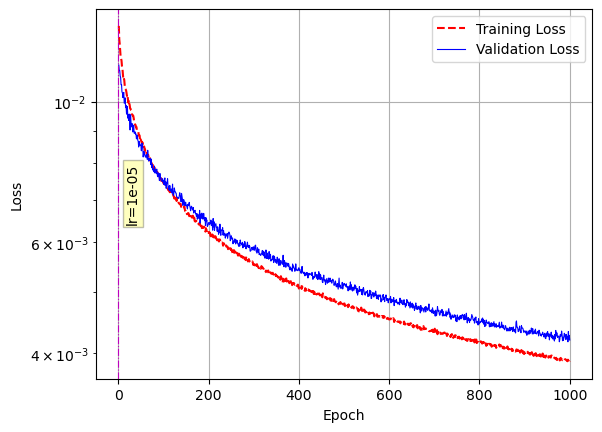



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 15 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************




--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 5e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
67/67 [==============================] - ETA: 0s - loss: 0.0068 - mse: 6.3725e-04 - NMSE: 0.0057 - covmat_fro_loss: 6.6198e-04 - tot_time: 0h 1m 10.3s

Epoch 1: val_NMSE improved from inf to 0.00356, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/checkpoint-15_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [===============

67/67 [==============================] - ETA: 0s - loss: 0.0064 - mse: 5.7410e-04 - NMSE: 0.0052 - covmat_fro_loss: 6.2997e-04 - tot_time: 0h 6m 32.1s

Epoch 13: val_NMSE did not improve from 0.00345
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s 394ms/step - loss: 0.0064 - mse: 5.7410e-04 - NMSE: 0.0052 - covmat_fro_loss: 6.3043e-04 - val_loss: 0.0052 - val_mse: 4.1422e-04 - val_NMSE: 0.0037 - val_covmat_fro_loss: 0.0000e+00
Epoch 14/1000
67/67 [==============================] - ETA: 0s - loss: 0.0063 - mse: 5.6934e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.2756e-04 - tot_time: 0h 6m 58.5s

Epoch 14: val_NMSE did not improve from 0.00345
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s 396ms/step - loss: 

Epoch 27/1000
67/67 [==============================] - ETA: 0s - loss: 0.0063 - mse: 5.6659e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.2169e-04 - tot_time: 0h 12m 47.1s

Epoch 27: val_NMSE did not improve from 0.00345
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s 397ms/step - loss: 0.0063 - mse: 5.6659e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.2161e-04 - val_loss: 0.0051 - val_mse: 3.9423e-04 - val_NMSE: 0.0035 - val_covmat_fro_loss: 0.0000e+00
Epoch 28/1000
67/67 [==============================] - ETA: 0s - loss: 0.0063 - mse: 5.6536e-04 - NMSE: 0.0051 - covmat_fro_loss: 6.2323e-04 - tot_time: 0h 13m 13.9s

Epoch 28: val_NMSE did not improve from 0.00345
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s 400

Epoch 41/1000
67/67 [==============================] - ETA: 0s - loss: 0.0062 - mse: 5.4687e-04 - NMSE: 0.0049 - covmat_fro_loss: 6.1218e-04 - tot_time: 0h 19m 2.0s

Epoch 41: val_NMSE did not improve from 0.00330
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s 398ms/step - loss: 0.0062 - mse: 5.4687e-04 - NMSE: 0.0049 - covmat_fro_loss: 6.1173e-04 - val_loss: 0.0052 - val_mse: 4.0404e-04 - val_NMSE: 0.0036 - val_covmat_fro_loss: 0.0000e+00
Epoch 42/1000
67/67 [==============================] - ETA: 0s - loss: 0.0062 - mse: 5.4716e-04 - NMSE: 0.0049 - covmat_fro_loss: 6.1467e-04 - tot_time: 0h 19m 28.5s

Epoch 42: val_NMSE did not improve from 0.00330
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s 396m

Epoch 55/1000
67/67 [==============================] - ETA: 0s - loss: 0.0061 - mse: 5.4085e-04 - NMSE: 0.0049 - covmat_fro_loss: 6.0800e-04 - tot_time: 0h 25m 15.2s

Epoch 55: val_NMSE did not improve from 0.00330
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s 403ms/step - loss: 0.0061 - mse: 5.4085e-04 - NMSE: 0.0049 - covmat_fro_loss: 6.0811e-04 - val_loss: 0.0050 - val_mse: 3.8279e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00
Epoch 56/1000
67/67 [==============================] - ETA: 0s - loss: 0.0061 - mse: 5.3695e-04 - NMSE: 0.0048 - covmat_fro_loss: 6.0632e-04 - tot_time: 0h 25m 41.7s

Epoch 56: val_NMSE did not improve from 0.00330
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s 395

Epoch 69/1000
67/67 [==============================] - ETA: 0s - loss: 0.0061 - mse: 5.3147e-04 - NMSE: 0.0048 - covmat_fro_loss: 6.0338e-04 - tot_time: 0h 31m 28.1s

Epoch 69: val_NMSE did not improve from 0.00330
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s 398ms/step - loss: 0.0061 - mse: 5.3147e-04 - NMSE: 0.0048 - covmat_fro_loss: 6.0281e-04 - val_loss: 0.0051 - val_mse: 3.9438e-04 - val_NMSE: 0.0035 - val_covmat_fro_loss: 0.0000e+00
Epoch 70/1000
67/67 [==============================] - ETA: 0s - loss: 0.0061 - mse: 5.3939e-04 - NMSE: 0.0049 - covmat_fro_loss: 6.0759e-04 - tot_time: 0h 31m 54.4s

Epoch 70: val_NMSE did not improve from 0.00330
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s 393

Epoch 83/1000
67/67 [==============================] - ETA: 0s - loss: 0.0060 - mse: 5.2563e-04 - NMSE: 0.0047 - covmat_fro_loss: 5.9907e-04 - tot_time: 0h 37m 41.2s

Epoch 83: val_NMSE did not improve from 0.00330
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s 396ms/step - loss: 0.0060 - mse: 5.2563e-04 - NMSE: 0.0047 - covmat_fro_loss: 5.9929e-04 - val_loss: 0.0050 - val_mse: 3.8733e-04 - val_NMSE: 0.0035 - val_covmat_fro_loss: 0.0000e+00
Epoch 84/1000
67/67 [==============================] - ETA: 0s - loss: 0.0060 - mse: 5.2155e-04 - NMSE: 0.0047 - covmat_fro_loss: 5.9864e-04 - tot_time: 0h 38m 7.7s

Epoch 84: val_NMSE did not improve from 0.00330
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s 396m

Epoch 97/1000
67/67 [==============================] - ETA: 0s - loss: 0.0060 - mse: 5.2143e-04 - NMSE: 0.0047 - covmat_fro_loss: 5.9669e-04 - tot_time: 0h 43m 54.6s

Epoch 97: val_NMSE did not improve from 0.00325
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s 396ms/step - loss: 0.0060 - mse: 5.2143e-04 - NMSE: 0.0047 - covmat_fro_loss: 5.9669e-04 - val_loss: 0.0051 - val_mse: 3.9772e-04 - val_NMSE: 0.0036 - val_covmat_fro_loss: 0.0000e+00
Epoch 98/1000
67/67 [==============================] - ETA: 0s - loss: 0.0059 - mse: 5.1618e-04 - NMSE: 0.0046 - covmat_fro_loss: 5.9346e-04 - tot_time: 0h 44m 21.1s

Epoch 98: val_NMSE did not improve from 0.00325
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s 397

Epoch 111/1000
67/67 [==============================] - ETA: 0s - loss: 0.0059 - mse: 5.1476e-04 - NMSE: 0.0046 - covmat_fro_loss: 5.9359e-04 - tot_time: 0h 50m 7.6s

Epoch 111: val_NMSE did not improve from 0.00325
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s 396ms/step - loss: 0.0059 - mse: 5.1476e-04 - NMSE: 0.0046 - covmat_fro_loss: 5.9402e-04 - val_loss: 0.0050 - val_mse: 3.8494e-04 - val_NMSE: 0.0035 - val_covmat_fro_loss: 0.0000e+00
Epoch 112/1000
67/67 [==============================] - ETA: 0s - loss: 0.0060 - mse: 5.2228e-04 - NMSE: 0.0047 - covmat_fro_loss: 5.9694e-04 - tot_time: 0h 50m 34.6s

Epoch 112: val_NMSE did not improve from 0.00325
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s 

Epoch 125/1000
67/67 [==============================] - ETA: 0s - loss: 0.0059 - mse: 5.0642e-04 - NMSE: 0.0046 - covmat_fro_loss: 5.8788e-04 - tot_time: 0h 56m 22.3s

Epoch 125: val_NMSE did not improve from 0.00325
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s 396ms/step - loss: 0.0059 - mse: 5.0642e-04 - NMSE: 0.0046 - covmat_fro_loss: 5.8770e-04 - val_loss: 0.0049 - val_mse: 3.6416e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00
Epoch 126/1000
67/67 [==============================] - ETA: 0s - loss: 0.0059 - mse: 5.0890e-04 - NMSE: 0.0046 - covmat_fro_loss: 5.9034e-04 - tot_time: 0h 56m 49.1s

Epoch 126: val_NMSE did not improve from 0.00325
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s

Epoch 139/1000
67/67 [==============================] - ETA: 0s - loss: 0.0059 - mse: 5.0435e-04 - NMSE: 0.0045 - covmat_fro_loss: 5.8666e-04 - tot_time: 1h 2m 35.4s

Epoch 139: val_NMSE did not improve from 0.00320
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s 395ms/step - loss: 0.0059 - mse: 5.0435e-04 - NMSE: 0.0045 - covmat_fro_loss: 5.8645e-04 - val_loss: 0.0049 - val_mse: 3.7321e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00
Epoch 140/1000
67/67 [==============================] - ETA: 0s - loss: 0.0058 - mse: 5.0153e-04 - NMSE: 0.0045 - covmat_fro_loss: 5.8657e-04 - tot_time: 1h 3m 2.1s

Epoch 140: val_NMSE did not improve from 0.00320
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s 39

Epoch 153/1000
67/67 [==============================] - ETA: 0s - loss: 0.0058 - mse: 5.0205e-04 - NMSE: 0.0045 - covmat_fro_loss: 5.8622e-04 - tot_time: 1h 8m 48.7s

Epoch 153: val_NMSE did not improve from 0.00320
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s 397ms/step - loss: 0.0058 - mse: 5.0205e-04 - NMSE: 0.0045 - covmat_fro_loss: 5.8749e-04 - val_loss: 0.0049 - val_mse: 3.7195e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00
Epoch 154/1000
67/67 [==============================] - ETA: 0s - loss: 0.0058 - mse: 4.9991e-04 - NMSE: 0.0045 - covmat_fro_loss: 5.8511e-04 - tot_time: 1h 9m 15.8s

Epoch 154: val_NMSE did not improve from 0.00320
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s 4

Epoch 167/1000
67/67 [==============================] - ETA: 0s - loss: 0.0058 - mse: 4.9373e-04 - NMSE: 0.0044 - covmat_fro_loss: 5.8171e-04 - tot_time: 1h 15m 2.2s

Epoch 167: val_NMSE did not improve from 0.00320
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s 390ms/step - loss: 0.0058 - mse: 4.9373e-04 - NMSE: 0.0044 - covmat_fro_loss: 5.8233e-04 - val_loss: 0.0049 - val_mse: 3.6821e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00
Epoch 168/1000
67/67 [==============================] - ETA: 0s - loss: 0.0057 - mse: 4.8893e-04 - NMSE: 0.0044 - covmat_fro_loss: 5.7774e-04 - tot_time: 1h 15m 28.8s

Epoch 168: val_NMSE did not improve from 0.00320
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s 

Epoch 181/1000
67/67 [==============================] - ETA: 0s - loss: 0.0058 - mse: 4.9550e-04 - NMSE: 0.0045 - covmat_fro_loss: 5.8017e-04 - tot_time: 1h 21m 15.6s

Epoch 181: val_NMSE did not improve from 0.00320
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s 402ms/step - loss: 0.0058 - mse: 4.9550e-04 - NMSE: 0.0045 - covmat_fro_loss: 5.8072e-04 - val_loss: 0.0049 - val_mse: 3.6401e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00
Epoch 182/1000
67/67 [==============================] - ETA: 0s - loss: 0.0057 - mse: 4.8689e-04 - NMSE: 0.0044 - covmat_fro_loss: 5.7611e-04 - tot_time: 1h 21m 42.0s

Epoch 182: val_NMSE did not improve from 0.00320
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s

Epoch 195/1000
67/67 [==============================] - ETA: 0s - loss: 0.0057 - mse: 4.8617e-04 - NMSE: 0.0044 - covmat_fro_loss: 5.7661e-04 - tot_time: 1h 27m 29.5s

Epoch 195: val_NMSE did not improve from 0.00320
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s 398ms/step - loss: 0.0057 - mse: 4.8617e-04 - NMSE: 0.0044 - covmat_fro_loss: 5.7700e-04 - val_loss: 0.0049 - val_mse: 3.6381e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00
Epoch 196/1000
67/67 [==============================] - ETA: 0s - loss: 0.0057 - mse: 4.8025e-04 - NMSE: 0.0043 - covmat_fro_loss: 5.7202e-04 - tot_time: 1h 27m 55.7s

Epoch 196: val_NMSE did not improve from 0.00320
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s

Epoch 209/1000
67/67 [==============================] - ETA: 0s - loss: 0.0057 - mse: 4.8322e-04 - NMSE: 0.0043 - covmat_fro_loss: 5.7319e-04 - tot_time: 1h 33m 39.9s

Epoch 209: val_NMSE did not improve from 0.00320
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s 395ms/step - loss: 0.0057 - mse: 4.8322e-04 - NMSE: 0.0043 - covmat_fro_loss: 5.7301e-04 - val_loss: 0.0048 - val_mse: 3.6005e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00
Epoch 210/1000
67/67 [==============================] - ETA: 0s - loss: 0.0057 - mse: 4.8081e-04 - NMSE: 0.0043 - covmat_fro_loss: 5.7411e-04 - tot_time: 1h 34m 6.5s

Epoch 210: val_NMSE did not improve from 0.00320
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s 

Epoch 223/1000
67/67 [==============================] - ETA: 0s - loss: 0.0057 - mse: 4.8382e-04 - NMSE: 0.0044 - covmat_fro_loss: 5.7298e-04 - tot_time: 1h 39m 52.1s

Epoch 223: val_NMSE did not improve from 0.00320
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s 403ms/step - loss: 0.0057 - mse: 4.8382e-04 - NMSE: 0.0044 - covmat_fro_loss: 5.7329e-04 - val_loss: 0.0049 - val_mse: 3.6075e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00
Epoch 224/1000
67/67 [==============================] - ETA: 0s - loss: 0.0057 - mse: 4.8418e-04 - NMSE: 0.0044 - covmat_fro_loss: 5.7464e-04 - tot_time: 1h 40m 19.3s

Epoch 224: val_NMSE did not improve from 0.00320
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s

Epoch 237/1000
67/67 [==============================] - ETA: 0s - loss: 0.0056 - mse: 4.7586e-04 - NMSE: 0.0043 - covmat_fro_loss: 5.6819e-04 - tot_time: 1h 46m 12.8s

Epoch 237: val_NMSE did not improve from 0.00319
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s 402ms/step - loss: 0.0056 - mse: 4.7586e-04 - NMSE: 0.0043 - covmat_fro_loss: 5.6831e-04 - val_loss: 0.0048 - val_mse: 3.6002e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00
Epoch 238/1000
67/67 [==============================] - ETA: 0s - loss: 0.0057 - mse: 4.7685e-04 - NMSE: 0.0043 - covmat_fro_loss: 5.7030e-04 - tot_time: 1h 46m 39.6s

Epoch 238: val_NMSE improved from 0.00319 to 0.00317, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/checkpoint-15_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLRO

Epoch 251/1000
67/67 [==============================] - ETA: 0s - loss: 0.0056 - mse: 4.7187e-04 - NMSE: 0.0042 - covmat_fro_loss: 5.6882e-04 - tot_time: 1h 52m 30.9s

Epoch 251: val_NMSE did not improve from 0.00315
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s 403ms/step - loss: 0.0056 - mse: 4.7187e-04 - NMSE: 0.0042 - covmat_fro_loss: 5.6884e-04 - val_loss: 0.0049 - val_mse: 3.6804e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00
Epoch 252/1000
67/67 [==============================] - ETA: 0s - loss: 0.0056 - mse: 4.7543e-04 - NMSE: 0.0043 - covmat_fro_loss: 5.6752e-04 - tot_time: 1h 52m 57.7s

Epoch 252: val_NMSE did not improve from 0.00315
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s

Epoch 265/1000
67/67 [==============================] - ETA: 0s - loss: 0.0056 - mse: 4.7136e-04 - NMSE: 0.0042 - covmat_fro_loss: 5.6743e-04 - tot_time: 1h 58m 46.8s

Epoch 265: val_NMSE did not improve from 0.00313
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s 403ms/step - loss: 0.0056 - mse: 4.7136e-04 - NMSE: 0.0042 - covmat_fro_loss: 5.6736e-04 - val_loss: 0.0049 - val_mse: 3.6754e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00
Epoch 266/1000
67/67 [==============================] - ETA: 0s - loss: 0.0056 - mse: 4.7079e-04 - NMSE: 0.0042 - covmat_fro_loss: 5.6589e-04 - tot_time: 1h 59m 13.3s

Epoch 266: val_NMSE did not improve from 0.00313
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s

Epoch 279/1000
67/67 [==============================] - ETA: 0s - loss: 0.0056 - mse: 4.6327e-04 - NMSE: 0.0042 - covmat_fro_loss: 5.6175e-04 - tot_time: 2h 4m 57.4s

Epoch 279: val_NMSE did not improve from 0.00313
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s 386ms/step - loss: 0.0056 - mse: 4.6327e-04 - NMSE: 0.0042 - covmat_fro_loss: 5.6256e-04 - val_loss: 0.0048 - val_mse: 3.5133e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00
Epoch 280/1000
67/67 [==============================] - ETA: 0s - loss: 0.0055 - mse: 4.5881e-04 - NMSE: 0.0041 - covmat_fro_loss: 5.5949e-04 - tot_time: 2h 5m 23.9s

Epoch 280: val_NMSE did not improve from 0.00313
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s 3

Epoch 293/1000
67/67 [==============================] - ETA: 0s - loss: 0.0056 - mse: 4.6326e-04 - NMSE: 0.0042 - covmat_fro_loss: 5.6194e-04 - tot_time: 2h 11m 5.9s

Epoch 293: val_NMSE did not improve from 0.00312
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s 397ms/step - loss: 0.0056 - mse: 4.6326e-04 - NMSE: 0.0042 - covmat_fro_loss: 5.6226e-04 - val_loss: 0.0048 - val_mse: 3.5093e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00
Epoch 294/1000
67/67 [==============================] - ETA: 0s - loss: 0.0055 - mse: 4.5784e-04 - NMSE: 0.0041 - covmat_fro_loss: 5.5995e-04 - tot_time: 2h 11m 31.8s

Epoch 294: val_NMSE did not improve from 0.00312
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s 

Epoch 307/1000
67/67 [==============================] - ETA: 0s - loss: 0.0056 - mse: 4.6740e-04 - NMSE: 0.0042 - covmat_fro_loss: 5.6239e-04 - tot_time: 2h 17m 13.1s

Epoch 307: val_NMSE did not improve from 0.00312
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s 401ms/step - loss: 0.0056 - mse: 4.6740e-04 - NMSE: 0.0042 - covmat_fro_loss: 5.6233e-04 - val_loss: 0.0048 - val_mse: 3.5684e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00
Epoch 308/1000
67/67 [==============================] - ETA: 0s - loss: 0.0055 - mse: 4.5848e-04 - NMSE: 0.0041 - covmat_fro_loss: 5.5942e-04 - tot_time: 2h 17m 40.0s

Epoch 308: val_NMSE did not improve from 0.00312
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s

Epoch 321/1000
67/67 [==============================] - ETA: 0s - loss: 0.0055 - mse: 4.6244e-04 - NMSE: 0.0042 - covmat_fro_loss: 5.6133e-04 - tot_time: 2h 23m 31.1s

Epoch 321: val_NMSE did not improve from 0.00311
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s 402ms/step - loss: 0.0055 - mse: 4.6244e-04 - NMSE: 0.0042 - covmat_fro_loss: 5.6243e-04 - val_loss: 0.0048 - val_mse: 3.5829e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00
Epoch 322/1000
67/67 [==============================] - ETA: 0s - loss: 0.0055 - mse: 4.5445e-04 - NMSE: 0.0041 - covmat_fro_loss: 5.5726e-04 - tot_time: 2h 23m 58.3s

Epoch 322: val_NMSE did not improve from 0.00311
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s

Epoch 335/1000
67/67 [==============================] - ETA: 0s - loss: 0.0055 - mse: 4.4914e-04 - NMSE: 0.0040 - covmat_fro_loss: 5.5360e-04 - tot_time: 2h 29m 46.9s

Epoch 335: val_NMSE did not improve from 0.00311
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s 409ms/step - loss: 0.0055 - mse: 4.4914e-04 - NMSE: 0.0040 - covmat_fro_loss: 5.5323e-04 - val_loss: 0.0048 - val_mse: 3.5398e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00
Epoch 336/1000
67/67 [==============================] - ETA: 0s - loss: 0.0054 - mse: 4.4448e-04 - NMSE: 0.0040 - covmat_fro_loss: 5.5135e-04 - tot_time: 2h 30m 13.8s

Epoch 336: val_NMSE did not improve from 0.00311
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s

Epoch 349/1000
67/67 [==============================] - ETA: 0s - loss: 0.0054 - mse: 4.4559e-04 - NMSE: 0.0040 - covmat_fro_loss: 5.5137e-04 - tot_time: 2h 36m 2.5s

Epoch 349: val_NMSE did not improve from 0.00311
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s 397ms/step - loss: 0.0054 - mse: 4.4559e-04 - NMSE: 0.0040 - covmat_fro_loss: 5.5096e-04 - val_loss: 0.0049 - val_mse: 3.6363e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00
Epoch 350/1000
67/67 [==============================] - ETA: 0s - loss: 0.0054 - mse: 4.4724e-04 - NMSE: 0.0040 - covmat_fro_loss: 5.5207e-04 - tot_time: 2h 36m 29.0s

Epoch 350: val_NMSE did not improve from 0.00311
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s 

Epoch 363/1000
67/67 [==============================] - ETA: 0s - loss: 0.0054 - mse: 4.4350e-04 - NMSE: 0.0040 - covmat_fro_loss: 5.5045e-04 - tot_time: 2h 42m 18.0s

Epoch 363: val_NMSE did not improve from 0.00311
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s 400ms/step - loss: 0.0054 - mse: 4.4350e-04 - NMSE: 0.0040 - covmat_fro_loss: 5.5022e-04 - val_loss: 0.0049 - val_mse: 3.6278e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00
Epoch 364/1000
67/67 [==============================] - ETA: 0s - loss: 0.0054 - mse: 4.4795e-04 - NMSE: 0.0040 - covmat_fro_loss: 5.5201e-04 - tot_time: 2h 42m 44.5s

Epoch 364: val_NMSE did not improve from 0.00311
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s

Epoch 377/1000
67/67 [==============================] - ETA: 0s - loss: 0.0054 - mse: 4.4132e-04 - NMSE: 0.0040 - covmat_fro_loss: 5.4847e-04 - tot_time: 2h 48m 35.3s

Epoch 377: val_NMSE did not improve from 0.00308
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s 407ms/step - loss: 0.0054 - mse: 4.4132e-04 - NMSE: 0.0040 - covmat_fro_loss: 5.4910e-04 - val_loss: 0.0048 - val_mse: 3.5294e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00
Epoch 378/1000
67/67 [==============================] - ETA: 0s - loss: 0.0054 - mse: 4.4269e-04 - NMSE: 0.0040 - covmat_fro_loss: 5.4918e-04 - tot_time: 2h 49m 1.8s

Epoch 378: val_NMSE did not improve from 0.00308
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s 

Epoch 391/1000
67/67 [==============================] - ETA: 0s - loss: 0.0054 - mse: 4.4356e-04 - NMSE: 0.0040 - covmat_fro_loss: 5.4959e-04 - tot_time: 2h 54m 48.3s

Epoch 391: val_NMSE did not improve from 0.00305
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s 393ms/step - loss: 0.0054 - mse: 4.4356e-04 - NMSE: 0.0040 - covmat_fro_loss: 5.4930e-04 - val_loss: 0.0048 - val_mse: 3.5721e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00
Epoch 392/1000
67/67 [==============================] - ETA: 0s - loss: 0.0054 - mse: 4.4540e-04 - NMSE: 0.0040 - covmat_fro_loss: 5.5140e-04 - tot_time: 2h 55m 15.2s

Epoch 392: val_NMSE did not improve from 0.00305
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s

Epoch 405/1000
67/67 [==============================] - ETA: 0s - loss: 0.0054 - mse: 4.4474e-04 - NMSE: 0.0040 - covmat_fro_loss: 5.4978e-04 - tot_time: 3h 1m 1.1s

Epoch 405: val_NMSE did not improve from 0.00305
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s 400ms/step - loss: 0.0054 - mse: 4.4474e-04 - NMSE: 0.0040 - covmat_fro_loss: 5.4972e-04 - val_loss: 0.0048 - val_mse: 3.5004e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00
Epoch 406/1000
67/67 [==============================] - ETA: 0s - loss: 0.0054 - mse: 4.3648e-04 - NMSE: 0.0039 - covmat_fro_loss: 5.4447e-04 - tot_time: 3h 1m 27.9s

Epoch 406: val_NMSE did not improve from 0.00305
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s 40

Epoch 419/1000
67/67 [==============================] - ETA: 0s - loss: 0.0053 - mse: 4.3319e-04 - NMSE: 0.0039 - covmat_fro_loss: 5.4217e-04 - tot_time: 3h 7m 15.2s

Epoch 419: val_NMSE did not improve from 0.00305
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s 401ms/step - loss: 0.0053 - mse: 4.3319e-04 - NMSE: 0.0039 - covmat_fro_loss: 5.4170e-04 - val_loss: 0.0048 - val_mse: 3.5746e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00
Epoch 420/1000
67/67 [==============================] - ETA: 0s - loss: 0.0054 - mse: 4.3628e-04 - NMSE: 0.0039 - covmat_fro_loss: 5.4442e-04 - tot_time: 3h 7m 42.0s

Epoch 420: val_NMSE did not improve from 0.00305
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s 4

Epoch 433/1000
67/67 [==============================] - ETA: 0s - loss: 0.0053 - mse: 4.3355e-04 - NMSE: 0.0039 - covmat_fro_loss: 5.4453e-04 - tot_time: 3h 13m 28.0s

Epoch 433: val_NMSE did not improve from 0.00305
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s 395ms/step - loss: 0.0053 - mse: 4.3355e-04 - NMSE: 0.0039 - covmat_fro_loss: 5.4404e-04 - val_loss: 0.0048 - val_mse: 3.6022e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00
Epoch 434/1000
67/67 [==============================] - ETA: 0s - loss: 0.0053 - mse: 4.3433e-04 - NMSE: 0.0039 - covmat_fro_loss: 5.4413e-04 - tot_time: 3h 13m 54.7s

Epoch 434: val_NMSE did not improve from 0.00305
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s

Epoch 447/1000
67/67 [==============================] - ETA: 0s - loss: 0.0054 - mse: 4.4163e-04 - NMSE: 0.0040 - covmat_fro_loss: 5.4704e-04 - tot_time: 3h 19m 41.3s

Epoch 447: val_NMSE did not improve from 0.00305
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s 407ms/step - loss: 0.0054 - mse: 4.4163e-04 - NMSE: 0.0040 - covmat_fro_loss: 5.4679e-04 - val_loss: 0.0048 - val_mse: 3.5708e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00
Epoch 448/1000
67/67 [==============================] - ETA: 0s - loss: 0.0053 - mse: 4.3391e-04 - NMSE: 0.0039 - covmat_fro_loss: 5.4278e-04 - tot_time: 3h 20m 8.1s

Epoch 448: val_NMSE did not improve from 0.00305
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s 

Epoch 461/1000
67/67 [==============================] - ETA: 0s - loss: 0.0053 - mse: 4.3002e-04 - NMSE: 0.0039 - covmat_fro_loss: 5.4072e-04 - tot_time: 3h 25m 54.6s

Epoch 461: val_NMSE did not improve from 0.00301
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s 402ms/step - loss: 0.0053 - mse: 4.3002e-04 - NMSE: 0.0039 - covmat_fro_loss: 5.4049e-04 - val_loss: 0.0047 - val_mse: 3.4008e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00
Epoch 462/1000
67/67 [==============================] - ETA: 0s - loss: 0.0053 - mse: 4.3399e-04 - NMSE: 0.0039 - covmat_fro_loss: 5.4281e-04 - tot_time: 3h 26m 20.8s

Epoch 462: val_NMSE did not improve from 0.00301
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s

Epoch 475/1000
67/67 [==============================] - ETA: 0s - loss: 0.0053 - mse: 4.2996e-04 - NMSE: 0.0039 - covmat_fro_loss: 5.4035e-04 - tot_time: 3h 32m 0.3s

Epoch 475: val_NMSE did not improve from 0.00301
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s 392ms/step - loss: 0.0053 - mse: 4.2996e-04 - NMSE: 0.0039 - covmat_fro_loss: 5.4003e-04 - val_loss: 0.0048 - val_mse: 3.5056e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00
Epoch 476/1000
67/67 [==============================] - ETA: 0s - loss: 0.0053 - mse: 4.2649e-04 - NMSE: 0.0038 - covmat_fro_loss: 5.3912e-04 - tot_time: 3h 32m 26.5s

Epoch 476: val_NMSE did not improve from 0.00301
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s 

Epoch 489/1000
67/67 [==============================] - ETA: 0s - loss: 0.0053 - mse: 4.2435e-04 - NMSE: 0.0038 - covmat_fro_loss: 5.3799e-04 - tot_time: 3h 38m 6.1s

Epoch 489: val_NMSE did not improve from 0.00301
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s 392ms/step - loss: 0.0053 - mse: 4.2435e-04 - NMSE: 0.0038 - covmat_fro_loss: 5.3820e-04 - val_loss: 0.0047 - val_mse: 3.4806e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00
Epoch 490/1000
67/67 [==============================] - ETA: 0s - loss: 0.0053 - mse: 4.2500e-04 - NMSE: 0.0038 - covmat_fro_loss: 5.3698e-04 - tot_time: 3h 38m 31.9s

Epoch 490: val_NMSE did not improve from 0.00301
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s 

Epoch 503/1000
67/67 [==============================] - ETA: 0s - loss: 0.0053 - mse: 4.2401e-04 - NMSE: 0.0038 - covmat_fro_loss: 5.3775e-04 - tot_time: 3h 44m 6.9s

Epoch 503: val_NMSE did not improve from 0.00301
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 25s 380ms/step - loss: 0.0053 - mse: 4.2401e-04 - NMSE: 0.0038 - covmat_fro_loss: 5.3777e-04 - val_loss: 0.0047 - val_mse: 3.4205e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00
Epoch 504/1000
67/67 [==============================] - ETA: 0s - loss: 0.0052 - mse: 4.2152e-04 - NMSE: 0.0038 - covmat_fro_loss: 5.3581e-04 - tot_time: 3h 44m 32.8s

Epoch 504: val_NMSE did not improve from 0.00301
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s 

Epoch 517/1000
67/67 [==============================] - ETA: 0s - loss: 0.0052 - mse: 4.2096e-04 - NMSE: 0.0038 - covmat_fro_loss: 5.3487e-04 - tot_time: 3h 50m 5.5s

Epoch 517: val_NMSE did not improve from 0.00301
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 25s 378ms/step - loss: 0.0052 - mse: 4.2096e-04 - NMSE: 0.0038 - covmat_fro_loss: 5.3486e-04 - val_loss: 0.0047 - val_mse: 3.4786e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00
Epoch 518/1000
67/67 [==============================] - ETA: 0s - loss: 0.0052 - mse: 4.1672e-04 - NMSE: 0.0038 - covmat_fro_loss: 5.3425e-04 - tot_time: 3h 50m 31.4s

Epoch 518: val_NMSE did not improve from 0.00301
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s 

Epoch 531/1000
67/67 [==============================] - ETA: 0s - loss: 0.0052 - mse: 4.1728e-04 - NMSE: 0.0038 - covmat_fro_loss: 5.3257e-04 - tot_time: 3h 56m 4.6s

Epoch 531: val_NMSE improved from 0.00301 to 0.00296, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/checkpoint-15_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s 396ms/step - loss: 0.0052 - mse: 4.1728e-04 - NMSE: 0.0038 - covmat_fro_loss: 5.3241e-04 - val_loss: 0.0046 - val_mse: 3.2920e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00
Epoch 532/1000
67/67 [==============================] - ETA: 0s - loss: 0.0052 - mse: 4.1304e-04 - NMSE: 0.0037 - covmat_fro_loss: 5.3129e-04 - tot_time: 3h 56m 31.4s

Epoch 532: val_NMSE did not improve from 0.00296
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM

Epoch 545/1000
67/67 [==============================] - ETA: 0s - loss: 0.0052 - mse: 4.1637e-04 - NMSE: 0.0037 - covmat_fro_loss: 5.3220e-04 - tot_time: 4h 2m 11.5s

Epoch 545: val_NMSE did not improve from 0.00296
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s 392ms/step - loss: 0.0052 - mse: 4.1637e-04 - NMSE: 0.0037 - covmat_fro_loss: 5.3157e-04 - val_loss: 0.0047 - val_mse: 3.4329e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00
Epoch 546/1000
67/67 [==============================] - ETA: 0s - loss: 0.0052 - mse: 4.1532e-04 - NMSE: 0.0037 - covmat_fro_loss: 5.3240e-04 - tot_time: 4h 2m 37.4s

Epoch 546: val_NMSE did not improve from 0.00296
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s 3

Epoch 559/1000
67/67 [==============================] - ETA: 0s - loss: 0.0052 - mse: 4.1290e-04 - NMSE: 0.0037 - covmat_fro_loss: 5.2982e-04 - tot_time: 4h 8m 24.7s

Epoch 559: val_NMSE did not improve from 0.00296
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 27s 403ms/step - loss: 0.0052 - mse: 4.1290e-04 - NMSE: 0.0037 - covmat_fro_loss: 5.2999e-04 - val_loss: 0.0047 - val_mse: 3.3970e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00
Epoch 560/1000
67/67 [==============================] - ETA: 0s - loss: 0.0052 - mse: 4.1956e-04 - NMSE: 0.0038 - covmat_fro_loss: 5.3508e-04 - tot_time: 4h 8m 50.8s

Epoch 560: val_NMSE did not improve from 0.00296
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s 3

Epoch 573/1000
67/67 [==============================] - ETA: 0s - loss: 0.0052 - mse: 4.1747e-04 - NMSE: 0.0038 - covmat_fro_loss: 5.3341e-04 - tot_time: 4h 14m 30.6s

Epoch 573: val_NMSE did not improve from 0.00296
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s 387ms/step - loss: 0.0052 - mse: 4.1747e-04 - NMSE: 0.0038 - covmat_fro_loss: 5.3277e-04 - val_loss: 0.0047 - val_mse: 3.3563e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00
Epoch 574/1000
67/67 [==============================] - ETA: 0s - loss: 0.0052 - mse: 4.1437e-04 - NMSE: 0.0037 - covmat_fro_loss: 5.3000e-04 - tot_time: 4h 14m 56.8s

Epoch 574: val_NMSE did not improve from 0.00296
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s

Epoch 587/1000
67/67 [==============================] - ETA: 0s - loss: 0.0051 - mse: 4.0374e-04 - NMSE: 0.0036 - covmat_fro_loss: 5.2529e-04 - tot_time: 4h 20m 36.9s

Epoch 587: val_NMSE did not improve from 0.00296
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s 388ms/step - loss: 0.0051 - mse: 4.0374e-04 - NMSE: 0.0036 - covmat_fro_loss: 5.2574e-04 - val_loss: 0.0047 - val_mse: 3.3598e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00
Epoch 588/1000
67/67 [==============================] - ETA: 0s - loss: 0.0052 - mse: 4.0984e-04 - NMSE: 0.0037 - covmat_fro_loss: 5.2922e-04 - tot_time: 4h 21m 3.0s

Epoch 588: val_NMSE did not improve from 0.00296
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s 

Epoch 601/1000
67/67 [==============================] - ETA: 0s - loss: 0.0051 - mse: 4.0883e-04 - NMSE: 0.0037 - covmat_fro_loss: 5.2727e-04 - tot_time: 4h 26m 42.3s

Epoch 601: val_NMSE did not improve from 0.00296
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s 393ms/step - loss: 0.0051 - mse: 4.0883e-04 - NMSE: 0.0037 - covmat_fro_loss: 5.2732e-04 - val_loss: 0.0047 - val_mse: 3.3778e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00
Epoch 602/1000
67/67 [==============================] - ETA: 0s - loss: 0.0052 - mse: 4.0974e-04 - NMSE: 0.0037 - covmat_fro_loss: 5.2710e-04 - tot_time: 4h 27m 8.5s

Epoch 602: val_NMSE did not improve from 0.00296
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s 

Epoch 615/1000
67/67 [==============================] - ETA: 0s - loss: 0.0052 - mse: 4.1194e-04 - NMSE: 0.0037 - covmat_fro_loss: 5.2804e-04 - tot_time: 4h 32m 47.0s

Epoch 615: val_NMSE did not improve from 0.00296
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s 385ms/step - loss: 0.0052 - mse: 4.1194e-04 - NMSE: 0.0037 - covmat_fro_loss: 5.2832e-04 - val_loss: 0.0047 - val_mse: 3.3914e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00
Epoch 616/1000
67/67 [==============================] - ETA: 0s - loss: 0.0051 - mse: 4.0392e-04 - NMSE: 0.0036 - covmat_fro_loss: 5.2376e-04 - tot_time: 4h 33m 12.9s

Epoch 616: val_NMSE did not improve from 0.00296
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 26s

Epoch 629/1000
67/67 [==============================] - ETA: 0s - loss: 0.0051 - mse: 3.9790e-04 - NMSE: 0.0036 - covmat_fro_loss: 5.1965e-04 - tot_time: 4h 38m 44.5s

Epoch 629: val_NMSE did not improve from 0.00296
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 25s 380ms/step - loss: 0.0051 - mse: 3.9790e-04 - NMSE: 0.0036 - covmat_fro_loss: 5.1973e-04 - val_loss: 0.0047 - val_mse: 3.4109e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00
Epoch 630/1000
67/67 [==============================] - ETA: 0s - loss: 0.0052 - mse: 4.1065e-04 - NMSE: 0.0037 - covmat_fro_loss: 5.2633e-04 - tot_time: 4h 39m 9.6s

Epoch 630: val_NMSE did not improve from 0.00296
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-15_outsteps
67/67 [==============================] - 25s 

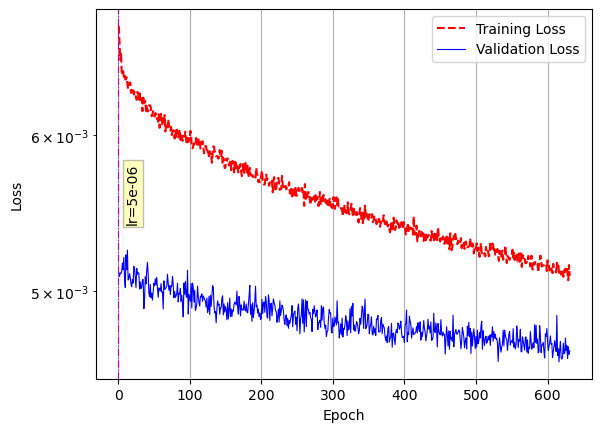



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 20 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************




--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
64/64 [==============================] - ETA: 0s - loss: 0.0090 - mse: 0.0010 - NMSE: 0.0092 - covmat_fro_loss: 9.3729e-04 - tot_time: 0h 1m 34.5s

Epoch 1: val_NMSE improved from inf to 0.00533, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/checkpoint-20_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-20_outsteps
64/64 [===================

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-20_outsteps
64/64 [==============================] - 26s 403ms/step - loss: 0.0086 - mse: 9.5911e-04 - NMSE: 0.0086 - covmat_fro_loss: 9.0694e-04 - val_loss: 0.0065 - val_mse: 6.3563e-04 - val_NMSE: 0.0057 - val_covmat_fro_loss: 0.0000e+00
Epoch 14/1000
64/64 [==============================] - ETA: 0s - loss: 0.0086 - mse: 9.6141e-04 - NMSE: 0.0087 - covmat_fro_loss: 9.1059e-04 - tot_time: 0h 7m 12.8s

Epoch 14: val_NMSE did not improve from 0.00532
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-20_outsteps
64/64 [==============================] - 26s 404ms/step - loss: 0.0086 - mse: 9.6141e-04 - NMSE: 0.0087 - covmat_fro_loss: 9.0977e-04 - val_loss: 0.0066 - val_mse: 6.5067e-04 - val_NMSE: 0.0059 - val_covmat_fro_loss: 0.0000e+00
Epoch 15/1000
64/64 [===============

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-20_outsteps
64/64 [==============================] - 26s 405ms/step - loss: 0.0085 - mse: 9.4545e-04 - NMSE: 0.0085 - covmat_fro_loss: 9.0210e-04 - val_loss: 0.0069 - val_mse: 6.8363e-04 - val_NMSE: 0.0062 - val_covmat_fro_loss: 0.0000e+00
Epoch 28/1000
64/64 [==============================] - ETA: 0s - loss: 0.0085 - mse: 9.3939e-04 - NMSE: 0.0085 - covmat_fro_loss: 9.0229e-04 - tot_time: 0h 13m 16.6s

Epoch 28: val_NMSE did not improve from 0.00532
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-20_outsteps
64/64 [==============================] - 26s 402ms/step - loss: 0.0085 - mse: 9.3939e-04 - NMSE: 0.0085 - covmat_fro_loss: 9.0258e-04 - val_loss: 0.0068 - val_mse: 6.6764e-04 - val_NMSE: 0.0060 - val_covmat_fro_loss: 0.0000e+00
Epoch 29/1000
64/64 [==============

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-20_outsteps
64/64 [==============================] - 26s 401ms/step - loss: 0.0085 - mse: 9.4725e-04 - NMSE: 0.0085 - covmat_fro_loss: 9.0263e-04 - val_loss: 0.0068 - val_mse: 6.7549e-04 - val_NMSE: 0.0061 - val_covmat_fro_loss: 0.0000e+00
Epoch 42/1000
64/64 [==============================] - ETA: 0s - loss: 0.0085 - mse: 9.3387e-04 - NMSE: 0.0084 - covmat_fro_loss: 8.9984e-04 - tot_time: 0h 19m 12.0s

Epoch 42: val_NMSE did not improve from 0.00532
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-20_outsteps
64/64 [==============================] - 25s 397ms/step - loss: 0.0085 - mse: 9.3387e-04 - NMSE: 0.0084 - covmat_fro_loss: 9.0108e-04 - val_loss: 0.0067 - val_mse: 6.6055e-04 - val_NMSE: 0.0059 - val_covmat_fro_loss: 0.0000e+00
Epoch 43/1000
64/64 [==============

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-20_outsteps
64/64 [==============================] - 25s 396ms/step - loss: 0.0084 - mse: 9.3292e-04 - NMSE: 0.0084 - covmat_fro_loss: 8.9735e-04 - val_loss: 0.0067 - val_mse: 6.6051e-04 - val_NMSE: 0.0059 - val_covmat_fro_loss: 0.0000e+00
Epoch 56/1000
64/64 [==============================] - ETA: 0s - loss: 0.0085 - mse: 9.4754e-04 - NMSE: 0.0085 - covmat_fro_loss: 8.9982e-04 - tot_time: 0h 25m 6.1s

Epoch 56: val_NMSE did not improve from 0.00532
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-20_outsteps
64/64 [==============================] - 25s 395ms/step - loss: 0.0085 - mse: 9.4754e-04 - NMSE: 0.0085 - covmat_fro_loss: 8.9916e-04 - val_loss: 0.0068 - val_mse: 6.7286e-04 - val_NMSE: 0.0061 - val_covmat_fro_loss: 0.0000e+00
Epoch 57/1000
64/64 [===============

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-20_outsteps
64/64 [==============================] - 25s 393ms/step - loss: 0.0085 - mse: 9.3450e-04 - NMSE: 0.0084 - covmat_fro_loss: 8.9763e-04 - val_loss: 0.0068 - val_mse: 6.7194e-04 - val_NMSE: 0.0060 - val_covmat_fro_loss: 0.0000e+00
Epoch 70/1000
64/64 [==============================] - ETA: 0s - loss: 0.0085 - mse: 9.3579e-04 - NMSE: 0.0084 - covmat_fro_loss: 9.0090e-04 - tot_time: 0h 31m 1.9s

Epoch 70: val_NMSE did not improve from 0.00532
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-20_outsteps
64/64 [==============================] - 26s 404ms/step - loss: 0.0085 - mse: 9.3579e-04 - NMSE: 0.0084 - covmat_fro_loss: 9.0135e-04 - val_loss: 0.0067 - val_mse: 6.6197e-04 - val_NMSE: 0.0060 - val_covmat_fro_loss: 0.0000e+00
Epoch 71/1000
64/64 [===============

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-20_outsteps
64/64 [==============================] - 26s 413ms/step - loss: 0.0084 - mse: 9.2992e-04 - NMSE: 0.0084 - covmat_fro_loss: 8.9404e-04 - val_loss: 0.0067 - val_mse: 6.6389e-04 - val_NMSE: 0.0060 - val_covmat_fro_loss: 0.0000e+00
Epoch 84/1000
64/64 [==============================] - ETA: 0s - loss: 0.0084 - mse: 9.2643e-04 - NMSE: 0.0083 - covmat_fro_loss: 8.9089e-04 - tot_time: 0h 37m 2.4s

Epoch 84: val_NMSE did not improve from 0.00532
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-20_outsteps
64/64 [==============================] - 26s 408ms/step - loss: 0.0084 - mse: 9.2643e-04 - NMSE: 0.0083 - covmat_fro_loss: 8.9234e-04 - val_loss: 0.0068 - val_mse: 6.6965e-04 - val_NMSE: 0.0060 - val_covmat_fro_loss: 0.0000e+00
Epoch 85/1000
64/64 [===============

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-20_outsteps
64/64 [==============================] - 26s 410ms/step - loss: 0.0083 - mse: 9.1675e-04 - NMSE: 0.0083 - covmat_fro_loss: 8.8865e-04 - val_loss: 0.0067 - val_mse: 6.6032e-04 - val_NMSE: 0.0059 - val_covmat_fro_loss: 0.0000e+00
Epoch 98/1000
64/64 [==============================] - ETA: 0s - loss: 0.0084 - mse: 9.2292e-04 - NMSE: 0.0083 - covmat_fro_loss: 8.9183e-04 - tot_time: 0h 43m 11.7s

Epoch 98: val_NMSE did not improve from 0.00532
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_012/checkpoints/LossHistoriesCheckpoint-20_outsteps
64/64 [==============================] - 26s 411ms/step - loss: 0.0084 - mse: 9.2292e-04 - NMSE: 0.0083 - covmat_fro_loss: 8.9165e-04 - val_loss: 0.0067 - val_mse: 6.6536e-04 - val_NMSE: 0.0060 - val_covmat_fro_loss: 0.0000e+00
Epoch 99/1000
64/64 [==============

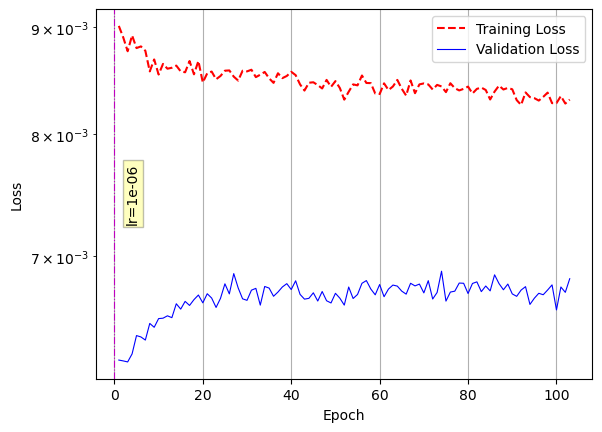

In [21]:
for kk in range(len(T_sample_output)):

    num_outsteps = int((T_sample_output[kk] + 0.5*dt_rnn)//dt_rnn)
    if type(freeze_layers) == type(None):
        freeze_layers_thisoutstep = []
    else:
        if kk > len(freeze_layers) - 1:
            freeze_layers_thisoutstep = freeze_layers[-1]
        else:
            freeze_layers_thisoutstep = freeze_layers[kk]
        
        if type(freeze_layers_thisoutstep) == type(None):
            freeze_layers_thisoutstep = []

    total_s_len = 80
    sep_lr_s = ' num_outsteps : {} '.format(num_outsteps)
    sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'>' + sep_lr_s
    sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'<'
    print('\n\n' + '*'*len(sep_lr_s))
    print('' + sep_lr_s+'')
    print('*'*len(sep_lr_s) + '\n\n')

    trainAERNN(
        create_data_for_RNN,
        Autoencoder,
        AR_RNN_GRU,
        all_data,
        AR_AERNN_GRU,
        dt_rnn=dt_rnn,
        T_sample_input=T_sample_input,
        T_sample_output=T_sample_output[kk],
        T_offset=T_offset,
        boundary_idx_arr=boundary_idx_arr,
        delta_t=delta_t,
        params=params,
        normalize_dataset=normalize_dataset,
        stddev_multiplier=stddev_multiplier,
        skip_intermediate=skip_intermediate,
        normalization_type=normalization_type,
        normalization_constant_arr_aedata=normalization_constant_arr_aedata,
        normalization_constant_arr_rnndata=normalization_arr_rnn,
        learning_rate_list=learning_rate_list[kk],
        epochs=epochs[kk],
        patience=patience[kk],
        loss_weights=loss_weights,
        min_delta=min_delta,
        lambda_reg=lambda_reg,
        stddev_rnn=stddev,
        stateful=False,
        behaviour=behaviour,
        strategy=strategy,
        dir_name_rnn=dir_name_rnn,
        dir_name_AR_AErnn=dir_name_ARrnn,
        batch_size=batch_size,
        load_file_rnn=load_file_rnn,
        wt_file_rnn=wt_file_rnn,
        load_file_ae=load_file_ae,
        wt_file_ae=wt_file_ae,
        covmat_lmda=covmat_lmda,
        readAndReturnLossHistories=readAndReturnLossHistories,
        mytimecallback=mytimecallback,
        plot_losses=plot_losses,
        SaveLosses=SaveLosses,
        train_split=train_split,
        test_split=test_split,
        val_split=val_split,
        freeze_layers=freeze_layers_thisoutstep,
        clipnorm=clipnorm,
    )
    
    wt_file_rnn = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_rnn_weights.h5'.format(num_outsteps)
    wt_file_ae = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_ae_weights.h5'.format(num_outsteps)

In [22]:
### Training the combined AE-RNN
